# Comparative Study of Optimisation Algorithms for Feed-Forward Neural Networks+



#### Notes: 
- Not all imports are in one place: Sometimes there are piecewise imports in each block. Purposeful, so that not all blocks have to be run in a linearly dependent order. 
- Docstrings are provided for documentation
- Some code has been removed: Some initially tried models and such were removed a long time ago during experimentation: What remains are the important codeblocks, as well as all code that was used in final results, tests or models

#### Initial imports and setup

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy 
import optuna 

torch.random.manual_seed(0)
numpy.random.seed(0)

# Load CSVs
train_df = pd.read_csv('Training.csv')
val_df = pd.read_csv('Validation.csv')

# Features and targets
X_train = train_df[['x1', 'x2', 'x3', 'x4']].values
y_train = train_df['y'].values.reshape(-1, 1)

X_val = val_df[['x1', 'x2', 'x3', 'x4']].values
y_val = val_df['y'].values.reshape(-1, 1)

# Standardise
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train = scaler_X.transform(X_train)
y_train = scaler_y.transform(y_train)

X_val = scaler_X.transform(X_val)
y_val = scaler_y.transform(y_val)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)


#### Architecture tuning using grid search:

In [ ]:
"""
Grid Search for Neural Network Architecture Evaluation

This script performs a simple grid search to evaluate different fully connected
neural network architectures on a regression task using PyTorch. The model is trained
on scaled inputs from a training CSV file and validated on a separate validation CSV.

Steps:
-------
1. **Imports and Reproducibility**: Sets global random seeds for NumPy and PyTorch.
2. **Data Loading and Preprocessing**:
   - Loads training and validation data from CSV files: 'Training.csv' and 'Validation.csv'.
   - Applies `StandardScaler` separately on `X` (features) and `y` (targets).
   - Converts data to PyTorch tensors.
3. **Architecture Grid Setup**:
   - A manually defined grid of `(n_layers, n_units)` combinations is iterated over.
4. **Training and Evaluation**:
   - For each architecture, a model is built using `nn.Sequential`.
   - Weights are initialized using Xavier normal.
   - The model is trained using SGD for 10 epochs.
   - Both training and validation Mean Squared Error (MSE) are recorded.
5. **Results Summary**:
   - Results are saved in a DataFrame and sorted by validation MSE.
   - The best performing architecture is displayed.

Returns:
--------
Prints a summary table of all architectures sorted by validation MSE,
as well as the best-performing architecture.

Instructions for Modifying:
----------------------------
- **Input Data**: Replace `'Training.csv'` and `'Validation.csv'` with your own file paths if needed.
- **Feature Columns**: Modify `['x1','x2','x3','x4']` if your feature column names differ.
- **Architecture Grid**: Modify the `arch_grid` list to test other layer/unit combinations.
- **Epochs**: Change the number of training epochs by adjusting the `range(10)` line.
- **Loss and Optimizer**: Swap out `nn.MSELoss()` or `optim.SGD(...)` for alternatives (e.g., Adam).
- **Device**: The script currently uses CPU only. To enable GPU, change `device = torch.device("cpu")` to:
  `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")`
- **Result Export**: You can write the `df` DataFrame to CSV using `df.to_csv("results.csv", index=False)` if needed.

Example Output:
---------------
Grid-search results (sorted by val MSE):

   n_layers  n_units  train_mse   val_mse
0         2       24   0.989429  0.987574
1         1       24   0.991087  0.987586
...
  Best architecture: 2 layers × 24 units  (val MSE=0.9876)


"""

# 1) Imports & Global Seeding
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np

# reproducibility
torch.manual_seed(0)
np.random.seed(0)

# 2) Load & Preprocess Data (CPU only)
train_df = pd.read_csv('Training.csv')
val_df   = pd.read_csv('Validation.csv')

# split out features / targets
X_train_np = train_df[['x1','x2','x3','x4']].values
y_train_np = train_df['y'].values.reshape(-1,1)
X_val_np   = val_df[['x1','x2','x3','x4']].values
y_val_np   = val_df['y'].values.reshape(-1,1)

from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler().fit(X_train_np)
scaler_y = StandardScaler().fit(y_train_np)
X_train_np = scaler_X.transform(X_train_np)
X_val_np   = scaler_X.transform(X_val_np)
y_train_np = scaler_y.transform(y_train_np)
y_val_np   = scaler_y.transform(y_val_np)

# to torch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
X_val   = torch.tensor(X_val_np,   dtype=torch.float32)
y_val   = torch.tensor(y_val_np,   dtype=torch.float32)

# 3) Grid of architectures to try

arch_grid = [
    (1, 24),  
    (2, 24),   
    (1, 8),  
    (2, 16),  
    (2, 20),   
    (2, 8),   
    (1, 16),  
]

# 4) Training loop

results = []
device = torch.device("cpu")

for n_layers, n_units in arch_grid:

    layers = []
    in_f   = X_train.shape[1]
    for _ in range(n_layers):
        layers += [nn.Linear(in_f, n_units), nn.ReLU()]
        in_f = n_units
    layers.append(nn.Linear(in_f, 1))
    model = nn.Sequential(*layers).to(device)
  
    for L in model.modules():
        if isinstance(L, nn.Linear):
            nn.init.xavier_normal_(L.weight)
            nn.init.zeros_(L.bias)

  
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

   
    train_loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=32, shuffle=True
    )

    # train 10 epochs
    model.train()
    for epoch in range(10):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    # evaluate
    model.eval()
    with torch.no_grad():
        train_mse = criterion(model(X_train), y_train).item()
        val_mse   = criterion(model(X_val),   y_val).item()

    results.append({
        "n_layers":   n_layers,
        "n_units":    n_units,
        "train_mse":  train_mse,
        "val_mse":    val_mse
    })

# 5) Summarize

df = pd.DataFrame(results)
df = df.sort_values("val_mse").reset_index(drop=True)
print("Grid-search results (sorted by val MSE):\n")
print(df)

best = df.iloc[0]
print(f"\n🏆  Best architecture: "
      f"{best.n_layers} layers × {best.n_units} units  "
      f"(val MSE={best.val_mse:.4f})")


Grid-search results (sorted by val MSE):

   n_layers  n_units  train_mse   val_mse
0         2       24   0.989429  0.987574
1         1       24   0.991087  0.987586
2         2       20   0.989687  0.988779
3         2       16   0.991191  0.990116
4         1       16   0.995888  0.994841
5         2        8   0.995200  0.996152
6         1        8   0.998301  0.999128

🏆  Best architecture: 2.0 layers × 24.0 units  (val MSE=0.9876)


#### Heaptmap for displaying arch:

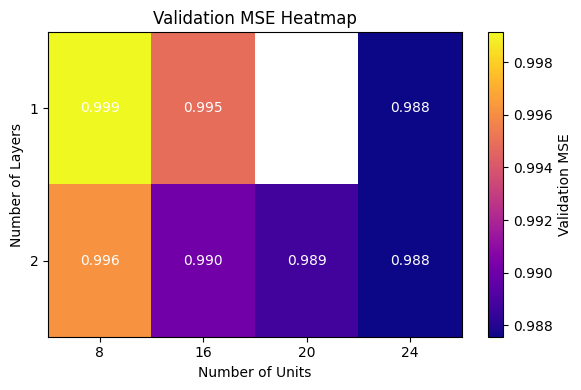

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Reconstruct your grid-search results
results = [
    {'n_layers': 2, 'n_units': 24, 'val_mse': 0.987574},
    {'n_layers': 1, 'n_units': 24, 'val_mse': 0.987586},
    {'n_layers': 2, 'n_units': 20, 'val_mse': 0.988779},
    {'n_layers': 2, 'n_units': 16, 'val_mse': 0.990116},
    {'n_layers': 1, 'n_units': 16, 'val_mse': 0.994841},
    {'n_layers': 2, 'n_units': 8,  'val_mse': 0.996152},
    {'n_layers': 1, 'n_units': 8,  'val_mse': 0.999128},
]
df = pd.DataFrame(results)

# 2) Pivot into matrix form
pivot = df.pivot(index='n_layers', columns='n_units', values='val_mse')

# 3) Plot
plt.figure(figsize=(6, 4))
plt.imshow(pivot, cmap='plasma', aspect='auto', interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('Validation MSE')

# 4) Axes
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel('Number of Units')
plt.ylabel('Number of Layers')
plt.title('Validation MSE Heatmap')

# 5) Annotate each cell with white text
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        v = pivot.values[i, j]
        plt.text(j, i, f"{v:.3f}",
                 ha='center', va='center',
                 color='white')

plt.tight_layout()
plt.show()


#### Using Optuna to do hyperparameter tuning for our stochastic gradient descent implementation: Finding optimal learning rate and momentum value.

In [ ]:
"""
Script for hyperparameter tuning using Optuna on a fixed neural network architecture.

This script builds a simple feedforward neural network (FFN) with two hidden layers 
and performs hyperparameter optimization using Optuna, specifically tuning learning 
rate (`lr`) and momentum (`momentum`) for stochastic gradient descent (SGD). 
The training is done using a batch size of 1 to simulate pure SGD. The goal is to 
minimize the mean squared error (MSE) on the validation set.

Sections:
---------
1. Fixed Model Definition:
    - Uses 2 hidden layers with 24 ReLU units each (modifiable).
    - Xavier initialization for weights and zero initialization for biases.

2. Optuna Search Objective:
    - Tunes learning rate (log-uniform between 1e-5 and 1e-1).
    - Tunes momentum (uniform between 0 and 0.99).
    - Trains for 10 epochs using batch size = 1.

3. Search Execution:
    - Runs 20 trials of optimization.
    - Reports the best validation MSE and corresponding hyperparameters.

How to Modify:
--------------
• **Architecture**: Change the number of hidden layers or units per layer 
  by editing `build_fixed_model()`. For example, change range(2) to range(3) for 
  3 hidden layers or change 24 to any other value for hidden size.

• **Loss Function**: Change `nn.MSELoss()` to other loss functions like MAE if needed.

• **Search Space**: To tune additional hyperparameters (e.g., batch size, number of units),
  add them to the `trial.suggest_*` section in `objective()` and modify `build_fixed_model()` accordingly.

• **Training Epochs**: Change the loop range in `objective()` (currently 10) to control how long 
  each trial is trained for.

• **Batch Size**: To switch from pure SGD to minibatch gradient descent, change 
  `batch_size=1` to another value in the DataLoader inside `objective()`.

Dependencies:
-------------
- torch
- numpy
- pandas
- optuna
- sklearn

Expected Inputs:
----------------
- `X_train`, `y_train`: torch.Tensors (features and labels for training)
- `X_val`, `y_val`: torch.Tensors (features and labels for validation)
  These must be preloaded in memory before running this script.

Outputs:
--------
- Console log showing best hyperparameters and corresponding validation MSE.

"""


import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# reproducibility
torch.manual_seed(0)
np.random.seed(0)

# 1) Fixed architecture builder
def build_fixed_model():
    layers = []
    in_f = X_train.shape[1]   
    for _ in range(2):        
        layers += [nn.Linear(in_f, 24), nn.ReLU()]
        in_f = 24
    layers.append(nn.Linear(in_f, 1))
    m = nn.Sequential(*layers)
    # Xavier init
    for L in m.modules():
        if isinstance(L, nn.Linear):
            nn.init.xavier_normal_(L.weight)
            nn.init.zeros_(L.bias)
    return m
# 2) Optuna objective – only lr & momentum, fix batch_size=1
def objective(trial):
    # Two params to tune
    lr       = trial.suggest_loguniform("lr",      1e-5, 1e-1)
    momentum = trial.suggest_float(  "momentum", 0.0, 0.99)

    #  DataLoader with batch_size=1
    train_loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=1,
        shuffle=True
    )

   # Build model, loss & optimizer
    model     = build_fixed_model()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    #  Train for 80 epochs
    model.train()
    for _ in range(10):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    #  Validation
    model.eval()
    with torch.no_grad():
        val_mse = criterion(model(X_val), y_val).item()
    return val_mse

# 3) Run the search
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

# 4) Report best
best = study.best_trial
print("\n=== Best Hyperparameters (pure SGD) ===")
print(f"  lr:       {best.params['lr']:.5g}")
print(f"  momentum: {best.params['momentum']:.4f}")
print(f"Best Val MSE: {best.value:.5f}")


[I 2025-05-28 18:42:30,770] A new study created in memory with name: no-name-29cfe234-123d-4b6d-a9b0-7c3f774a1328
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_5499/2176302026.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr       = trial.suggest_loguniform("lr",      1e-5, 1e-1)
Best trial: 0. Best value: 1.01949:   5%|▌         | 1/20 [01:14<23:44, 74.96s/it]

[I 2025-05-28 18:43:45,730] Trial 0 finished with value: 1.019486665725708 and parameters: {'lr': 0.07722597496556405, 'momentum': 0.68862897675173}. Best is trial 0 with value: 1.019486665725708.


Best trial: 1. Best value: 0.863264:  10%|█         | 2/20 [02:30<22:32, 75.13s/it]

[I 2025-05-28 18:45:00,975] Trial 1 finished with value: 0.8632642030715942 and parameters: {'lr': 0.002491034301035869, 'momentum': 0.6706817605204999}. Best is trial 1 with value: 0.8632642030715942.


Best trial: 1. Best value: 0.863264:  15%|█▌        | 3/20 [03:44<21:11, 74.78s/it]

[I 2025-05-28 18:46:15,345] Trial 2 finished with value: 1.008341908454895 and parameters: {'lr': 0.02926027577397731, 'momentum': 0.11218386033409711}. Best is trial 1 with value: 0.8632642030715942.


Best trial: 1. Best value: 0.863264:  20%|██        | 4/20 [04:59<19:54, 74.65s/it]

[I 2025-05-28 18:47:29,802] Trial 3 finished with value: 0.9851898550987244 and parameters: {'lr': 0.00893774459776824, 'momentum': 0.5399565006032588}. Best is trial 1 with value: 0.8632642030715942.


Best trial: 1. Best value: 0.863264:  25%|██▌       | 5/20 [06:13<18:39, 74.63s/it]

[I 2025-05-28 18:48:44,391] Trial 4 finished with value: 0.9964484572410583 and parameters: {'lr': 4.80326942588253e-05, 'momentum': 0.08237666225046819}. Best is trial 1 with value: 0.8632642030715942.


Best trial: 1. Best value: 0.863264:  30%|███       | 6/20 [07:27<17:22, 74.50s/it]

[I 2025-05-28 18:49:58,629] Trial 5 finished with value: 0.9977979063987732 and parameters: {'lr': 1.3879333944853265e-05, 'momentum': 0.621887448671995}. Best is trial 1 with value: 0.8632642030715942.


Best trial: 1. Best value: 0.863264:  35%|███▌      | 7/20 [08:42<16:09, 74.55s/it]

[W 2025-05-28 18:51:13,284] Trial 6 failed with parameters: {'lr': 0.0693368760229596, 'momentum': 0.6561466262131057} because of the following error: The value nan is not acceptable.
[W 2025-05-28 18:51:13,287] Trial 6 failed with value nan.


Best trial: 1. Best value: 0.863264:  40%|████      | 8/20 [09:56<14:53, 74.49s/it]

[I 2025-05-28 18:52:27,660] Trial 7 finished with value: 0.8716850280761719 and parameters: {'lr': 0.004083592137636449, 'momentum': 0.1948592692793183}. Best is trial 1 with value: 0.8632642030715942.


Best trial: 1. Best value: 0.863264:  45%|████▌     | 9/20 [11:11<13:39, 74.50s/it]

[I 2025-05-28 18:53:42,167] Trial 8 finished with value: 0.9257376790046692 and parameters: {'lr': 0.009614876416667221, 'momentum': 0.39769380793625425}. Best is trial 1 with value: 0.8632642030715942.


Best trial: 1. Best value: 0.863264:  50%|█████     | 10/20 [12:26<12:25, 74.55s/it]

[I 2025-05-28 18:54:56,846] Trial 9 finished with value: 0.9045374989509583 and parameters: {'lr': 0.0022883990537292363, 'momentum': 0.7195431992810583}. Best is trial 1 with value: 0.8632642030715942.


Best trial: 1. Best value: 0.863264:  55%|█████▌    | 11/20 [13:40<11:10, 74.46s/it]

[I 2025-05-28 18:56:11,099] Trial 10 finished with value: 0.9899379014968872 and parameters: {'lr': 0.00010944626772812799, 'momentum': 0.3367779849354335}. Best is trial 1 with value: 0.8632642030715942.


Best trial: 1. Best value: 0.863264:  60%|██████    | 12/20 [14:54<09:55, 74.45s/it]

[I 2025-05-28 18:57:25,513] Trial 11 finished with value: 0.9432251453399658 and parameters: {'lr': 0.0002997376745477513, 'momentum': 0.9790257780084946}. Best is trial 1 with value: 0.8632642030715942.


Best trial: 1. Best value: 0.863264:  65%|██████▌   | 13/20 [16:08<08:39, 74.28s/it]

[I 2025-05-28 18:58:39,417] Trial 12 finished with value: 0.965964138507843 and parameters: {'lr': 0.0015662068029184029, 'momentum': 0.2451522199571834}. Best is trial 1 with value: 0.8632642030715942.


Best trial: 13. Best value: 0.850097:  70%|███████   | 14/20 [17:22<07:25, 74.24s/it]

[I 2025-05-28 18:59:53,570] Trial 13 finished with value: 0.8500973582267761 and parameters: {'lr': 0.0005680703916186882, 'momentum': 0.8732847818815674}. Best is trial 13 with value: 0.8500973582267761.


Best trial: 14. Best value: 0.79692:  75%|███████▌  | 15/20 [18:36<06:10, 74.19s/it] 

[I 2025-05-28 19:01:07,647] Trial 14 finished with value: 0.7969197630882263 and parameters: {'lr': 0.0004872119511159354, 'momentum': 0.8766164307306744}. Best is trial 14 with value: 0.7969197630882263.


Best trial: 14. Best value: 0.79692:  80%|████████  | 16/20 [19:50<04:56, 74.16s/it]

[I 2025-05-28 19:02:21,717] Trial 15 finished with value: 0.908641517162323 and parameters: {'lr': 0.00037484338849541106, 'momentum': 0.9445571334860606}. Best is trial 14 with value: 0.7969197630882263.


Best trial: 14. Best value: 0.79692:  85%|████████▌ | 17/20 [21:04<03:42, 74.10s/it]

[I 2025-05-28 19:03:35,671] Trial 16 finished with value: 0.8646453022956848 and parameters: {'lr': 0.00048517453693837256, 'momentum': 0.8251558057957358}. Best is trial 14 with value: 0.7969197630882263.


Best trial: 14. Best value: 0.79692:  90%|█████████ | 18/20 [22:19<02:28, 74.10s/it]

[I 2025-05-28 19:04:49,793] Trial 17 finished with value: 0.9784354567527771 and parameters: {'lr': 9.173144461117463e-05, 'momentum': 0.8073786826673773}. Best is trial 14 with value: 0.7969197630882263.


Best trial: 14. Best value: 0.79692:  95%|█████████▌| 19/20 [23:32<01:14, 74.05s/it]

[I 2025-05-28 19:06:03,735] Trial 18 finished with value: 0.9212556481361389 and parameters: {'lr': 0.0008223197638385264, 'momentum': 0.8744406649023867}. Best is trial 14 with value: 0.7969197630882263.


Best trial: 14. Best value: 0.79692: 100%|██████████| 20/20 [24:46<00:00, 74.32s/it]

[I 2025-05-28 19:07:17,238] Trial 19 finished with value: 0.9900429248809814 and parameters: {'lr': 0.00016307254326817386, 'momentum': 0.522156351647615}. Best is trial 14 with value: 0.7969197630882263.

=== Best Hyperparameters (pure SGD) ===
  lr:       0.00048721
  momentum: 0.8766
Best Val MSE: 0.79692


#### SGD run using parameters found with optuna: 

Using device: cpu

Epoch   1/100 ▶ train MSE: 1.0027, val MSE: 0.9923
Epoch   2/100 ▶ train MSE: 0.9970, val MSE: 0.9871
Epoch   3/100 ▶ train MSE: 0.9940, val MSE: 0.9912
Epoch   4/100 ▶ train MSE: 0.9920, val MSE: 0.9927
Epoch   5/100 ▶ train MSE: 0.9908, val MSE: 0.9839
Epoch   6/100 ▶ train MSE: 0.9884, val MSE: 0.9777
Epoch   7/100 ▶ train MSE: 0.9875, val MSE: 0.9817
Epoch   8/100 ▶ train MSE: 0.9840, val MSE: 0.9875
Epoch   9/100 ▶ train MSE: 0.9798, val MSE: 0.9822
Epoch  10/100 ▶ train MSE: 0.9705, val MSE: 0.9191
Epoch  11/100 ▶ train MSE: 0.9517, val MSE: 0.8930
Epoch  12/100 ▶ train MSE: 0.9389, val MSE: 0.8855
Epoch  13/100 ▶ train MSE: 0.9265, val MSE: 0.8699
Epoch  14/100 ▶ train MSE: 0.9180, val MSE: 0.8634
Epoch  15/100 ▶ train MSE: 0.9126, val MSE: 0.8345
Epoch  16/100 ▶ train MSE: 0.9068, val MSE: 0.8344
Epoch  17/100 ▶ train MSE: 0.9012, val MSE: 0.8410
Epoch  18/100 ▶ train MSE: 0.8934, val MSE: 0.8000
Epoch  19/100 ▶ train MSE: 0.8846, val MSE: 0.7904
Epoch  20/10

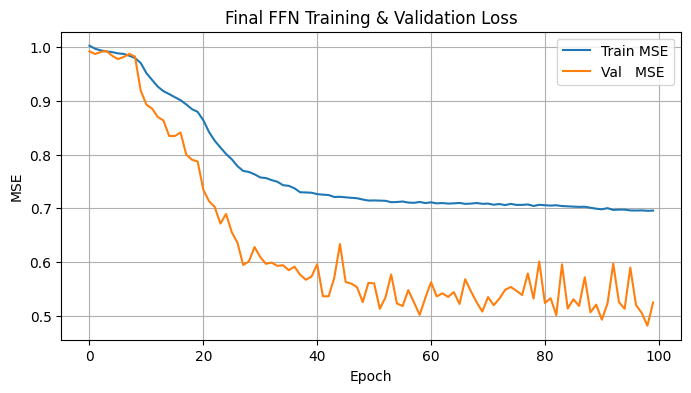


✅ SGD‐trained model and metadata saved to `checkpoints_sgd/`


In [ ]:

"""
Final Feed-Forward Network (FFN) Training Script with Best Hyperparameters (SGD)

Overview:
---------
This script trains a fixed-architecture FFN on preprocessed training data using
Stochastic Gradient Descent (SGD) with Optuna-optimized hyperparameters. It logs
performance metrics (MSE) per epoch, plots loss curves, and saves the model, weights,
and architecture metadata for future reuse.

Sections:
---------
1. Device Setup         – Forces CPU or uses CUDA if available.
2. Hyperparameter Dict  – Update this section with new best hyperparameters if needed.
3. Data Preparation     – Assumes X_train, y_train, X_val, y_val are already scaled and defined.
4. Model Construction   – Dynamically builds a model with specified layers/activation.
5. Training Loop        – Runs for 100 epochs with SGD, logs per-epoch MSE to CSV.
6. Performance Plotting – Visualises train vs val loss curves.
7. Checkpointing        – Saves model weights, flattened vector, and architecture metadata.

Customisation Instructions:
---------------------------
- To change the architecture:
  ↳ Edit `best_params["n_layers"]` or `["n_units"]`, and optionally the activation function.
- To change the training duration:
  ↳ Modify the `epochs` variable (currently set to 100).
- To use a different batch size or optimizer:
  ↳ Update the `best_params["batch_size"]` and/or swap out `optim.SGD` with another optimizer.
- To enable GPU:
  ↳ Uncomment the `cuda` line in device setup.
- To retrain with different data:
  ↳ Make sure to redefine `X_train`, `y_train`, `X_val`, `y_val` with properly preprocessed tensors.

Output:
-------
- `checkpoints_sgd/sgd_final_weights.pth`        – Trained PyTorch state_dict.
- `checkpoints_sgd/sgd_final_genome.npy`         – Flattened model parameter vector.
- `checkpoints_sgd/sgd_model_meta.json`          – Model and training metadata.
- `sgd_stats.csv`                                – CSV log of train/val MSE per epoch.
- Train vs Val loss plot displayed at end.
"""

#  Final FFN Training with Best Hyperparameters
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# 1) Device: CPU 
device = torch.device("cpu")
print(f"Using device: {device}\n")

best_params = {
    "lr":         0.00048721,
    "momentum":   0.8766,
    "batch_size": 1,
    "n_layers":   2,
    "n_units":    24,
    "activation": "ReLU"
}
# 3) Prepare DataLoaders (assumes X_train, y_train, X_val, y_val already defined & scaled)
train_ds = TensorDataset(X_train.to(device), y_train.to(device))
val_ds   = TensorDataset(X_val.to(device),   y_val.to(device))
train_loader = DataLoader(train_ds,
                          batch_size=best_params["batch_size"],
                          shuffle=True)
# we'll just evaluate on the full validation set each epoch
Xv, yv = X_val.to(device), y_val.to(device)

# 4) Build the model
layers = []
in_f = X_train.shape[1]
Act  = getattr(nn, best_params["activation"])
for _ in range(best_params["n_layers"]):
    layers += [nn.Linear(in_f, best_params["n_units"]), Act()]
    in_f = best_params["n_units"]
layers.append(nn.Linear(in_f, 1))
model = nn.Sequential(*layers).to(device)

# 5) Optimizer & loss
optimizer = optim.SGD(model.parameters(),
                      lr=best_params["lr"],
                      momentum=best_params["momentum"])
criterion = nn.MSELoss()
SGD_LOG_FN = "sgd_stats.csv"
with open(SGD_LOG_FN, "w") as f:
    f.write("epoch,epoch_time,train_mse,val_mse\n")
# 6) Train for 100 epochs
epochs = 100
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    start_time = time.time()
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)
    train_mse = running / len(train_loader.dataset)
    train_losses.append(train_mse)
    model.eval()
    with torch.no_grad():
        val_mse = criterion(model(Xv), yv).item()
    val_losses.append(val_mse)
    epoch_time = time.time() - start_time
    with open(SGD_LOG_FN, "a") as f:
        f.write(f"{epoch},{epoch_time:.6f},{train_mse:.6f},{val_mse:.6f}\n")
   
    print(f"Epoch {epoch:3d}/{epochs} ▶ train MSE: {train_mse:.4f}, val MSE: {val_mse:.4f}")
print("\n✅ Training complete!")

# 7) Plot curves
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses,   label="Val   MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Final FFN Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

import os, json, numpy as np
from torch.nn.utils import parameters_to_vector

# Saving params for later re use:
os.makedirs("checkpoints_sgd", exist_ok=True)

# 1) Save the PyTorch state_dict
torch.save(model.state_dict(),
           "checkpoints_sgd/sgd_final_weights.pth")

# 2) Save the flat parameter vector (so you can reload via vector_to_parameters)
genome_sgd = parameters_to_vector(model.parameters()).detach().cpu().numpy()
np.save("checkpoints_sgd/sgd_final_genome.npy", genome_sgd)

# 3) Save the architecture & SGD hyperparams so you can rebuild the same model later
meta_sgd = {
    "arch": {
        "n_layers":   best_params["n_layers"],
        "n_units":    best_params["n_units"],
        "activation": best_params["activation"]
    },
    "sgd_params": {
        "lr":       best_params["lr"],
        "momentum": best_params["momentum"],
        "batch_size": best_params["batch_size"],
        "epochs":    epochs
    }
}
with open("checkpoints_sgd/sgd_model_meta.json","w") as fp:
    json.dump(meta_sgd, fp, indent=2)

print("\n✅ SGD‐trained model and metadata saved to `checkpoints_sgd/`")


#### Using Optuna to do hyperparameter tuning for our L-BFGS implementation: Finding optimal learning rate, max iterations, and epochs.

[I 2025-05-28 14:19:21,785] A new study created in memory with name: no-name-3a70d6ab-00f9-4d41-9a48-558d13cc2b69
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_5499/59883290.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr       = trial.suggest_loguniform("lr",      1e-2, 10.0)
  5%|▌         | 1/20 [00:11<03:41, 11.64s/it]

[W 2025-05-28 14:19:33,431] Trial 0 failed with parameters: {'lr': 2.08981369921552, 'max_iter': 50, 'epochs': 40} because of the following error: The value nan is not acceptable.
[W 2025-05-28 14:19:33,434] Trial 0 failed with value nan.


 10%|█         | 2/20 [00:13<01:50,  6.16s/it]

[W 2025-05-28 14:19:35,750] Trial 1 failed with parameters: {'lr': 2.2316699775559283, 'max_iter': 10, 'epochs': 40} because of the following error: The value nan is not acceptable.
[W 2025-05-28 14:19:35,752] Trial 1 failed with value nan.


Best trial: 2. Best value: 0.635706:  15%|█▌        | 3/20 [00:20<01:44,  6.16s/it]

[I 2025-05-28 14:19:41,907] Trial 2 finished with value: 0.6357057094573975 and parameters: {'lr': 0.041762790769269996, 'max_iter': 10, 'epochs': 100}. Best is trial 2 with value: 0.6357057094573975.


Best trial: 3. Best value: 0.431403:  20%|██        | 4/20 [00:26<01:43,  6.44s/it]

[I 2025-05-28 14:19:48,779] Trial 3 finished with value: 0.4314032196998596 and parameters: {'lr': 0.06168203583807849, 'max_iter': 20, 'epochs': 60}. Best is trial 3 with value: 0.4314032196998596.


Best trial: 4. Best value: 0.347137:  25%|██▌       | 5/20 [00:34<01:39,  6.65s/it]

[I 2025-05-28 14:19:55,807] Trial 4 finished with value: 0.3471372723579407 and parameters: {'lr': 1.3615240458927713, 'max_iter': 20, 'epochs': 60}. Best is trial 4 with value: 0.3471372723579407.


Best trial: 4. Best value: 0.347137:  30%|███       | 6/20 [00:39<01:29,  6.36s/it]

[I 2025-05-28 14:20:01,597] Trial 5 finished with value: 0.4124971330165863 and parameters: {'lr': 0.10160487871637558, 'max_iter': 10, 'epochs': 100}. Best is trial 4 with value: 0.3471372723579407.


Best trial: 4. Best value: 0.347137:  35%|███▌      | 7/20 [01:04<02:41, 12.41s/it]

[W 2025-05-28 14:20:26,453] Trial 6 failed with parameters: {'lr': 4.5260308447550655, 'max_iter': 50, 'epochs': 100} because of the following error: The value nan is not acceptable.
[W 2025-05-28 14:20:26,455] Trial 6 failed with value nan.


Best trial: 4. Best value: 0.347137:  40%|████      | 8/20 [01:27<03:10, 15.84s/it]

[W 2025-05-28 14:20:49,639] Trial 7 failed with parameters: {'lr': 0.011931180028593898, 'max_iter': 50, 'epochs': 80} because of the following error: The value nan is not acceptable.
[W 2025-05-28 14:20:49,642] Trial 7 failed with value nan.


Best trial: 4. Best value: 0.347137:  45%|████▌     | 9/20 [01:44<02:55, 15.96s/it]

[W 2025-05-28 14:21:05,860] Trial 8 failed with parameters: {'lr': 1.9211059060929936, 'max_iter': 50, 'epochs': 60} because of the following error: The value nan is not acceptable.
[W 2025-05-28 14:21:05,863] Trial 8 failed with value nan.


Best trial: 4. Best value: 0.347137:  50%|█████     | 10/20 [01:48<02:02, 12.27s/it]

[W 2025-05-28 14:21:09,877] Trial 9 failed with parameters: {'lr': 9.009499918610667, 'max_iter': 20, 'epochs': 40} because of the following error: The value nan is not acceptable.
[W 2025-05-28 14:21:09,879] Trial 9 failed with value nan.


Best trial: 4. Best value: 0.347137:  55%|█████▌    | 11/20 [01:51<01:25,  9.54s/it]

[I 2025-05-28 14:21:13,220] Trial 10 finished with value: 0.4225972294807434 and parameters: {'lr': 0.2792263989562056, 'max_iter': 10, 'epochs': 60}. Best is trial 4 with value: 0.3471372723579407.


Best trial: 4. Best value: 0.347137:  60%|██████    | 12/20 [01:59<01:12,  9.01s/it]

[W 2025-05-28 14:21:21,020] Trial 11 failed with parameters: {'lr': 4.108316983113093, 'max_iter': 20, 'epochs': 80} because of the following error: The value nan is not acceptable.
[W 2025-05-28 14:21:21,023] Trial 11 failed with value nan.


Best trial: 4. Best value: 0.347137:  65%|██████▌   | 13/20 [02:00<00:46,  6.66s/it]

[I 2025-05-28 14:21:22,281] Trial 12 finished with value: 0.7582546472549438 and parameters: {'lr': 0.16338714361958181, 'max_iter': 10, 'epochs': 20}. Best is trial 4 with value: 0.3471372723579407.


Best trial: 4. Best value: 0.347137:  70%|███████   | 14/20 [02:02<00:31,  5.26s/it]

[W 2025-05-28 14:21:24,309] Trial 13 failed with parameters: {'lr': 9.385566437479376, 'max_iter': 20, 'epochs': 20} because of the following error: The value nan is not acceptable.
[W 2025-05-28 14:21:24,312] Trial 13 failed with value nan.


Best trial: 4. Best value: 0.347137:  75%|███████▌  | 15/20 [02:28<00:56, 11.36s/it]

[W 2025-05-28 14:21:49,808] Trial 14 failed with parameters: {'lr': 7.919467830773519, 'max_iter': 50, 'epochs': 100} because of the following error: The value nan is not acceptable.
[W 2025-05-28 14:21:49,811] Trial 14 failed with value nan.


Best trial: 4. Best value: 0.347137:  80%|████████  | 16/20 [02:30<00:34,  8.67s/it]

[I 2025-05-28 14:21:52,220] Trial 15 finished with value: 0.9797548651695251 and parameters: {'lr': 0.01422571893517124, 'max_iter': 10, 'epochs': 40}. Best is trial 4 with value: 0.3471372723579407.


Best trial: 16. Best value: 0.210479:  85%|████████▌ | 17/20 [02:34<00:22,  7.42s/it]

[I 2025-05-28 14:21:56,730] Trial 16 finished with value: 0.2104787528514862 and parameters: {'lr': 0.6843929977747965, 'max_iter': 10, 'epochs': 80}. Best is trial 16 with value: 0.2104787528514862.


Best trial: 16. Best value: 0.210479:  90%|█████████ | 18/20 [02:39<00:12,  6.43s/it]

[W 2025-05-28 14:22:00,843] Trial 17 failed with parameters: {'lr': 2.7875555078900844, 'max_iter': 10, 'epochs': 80} because of the following error: The value nan is not acceptable.
[W 2025-05-28 14:22:00,846] Trial 17 failed with value nan.


Best trial: 16. Best value: 0.210479:  95%|█████████▌| 19/20 [02:44<00:06,  6.26s/it]

[W 2025-05-28 14:22:06,714] Trial 18 failed with parameters: {'lr': 0.03772030648482473, 'max_iter': 10, 'epochs': 100} because of the following error: The value nan is not acceptable.
[W 2025-05-28 14:22:06,716] Trial 18 failed with value nan.


Best trial: 19. Best value: 0.184061: 100%|██████████| 20/20 [02:56<00:00,  8.84s/it]


[I 2025-05-28 14:22:18,656] Trial 19 finished with value: 0.1840611696243286 and parameters: {'lr': 0.9669461523303573, 'max_iter': 20, 'epochs': 100}. Best is trial 19 with value: 0.1840611696243286.

🏆 Best L-BFGS Config:
  lr: 0.9669461523303573
  max_iter: 20
  epochs: 100
Best Validation MSE: 0.18406

Epoch 1/100 ▶ train MSE: 1.4198, val MSE: 0.9929
Epoch 20/100 ▶ train MSE: 0.7260, val MSE: 0.5253
Epoch 40/100 ▶ train MSE: 0.6450, val MSE: 0.4130
Epoch 60/100 ▶ train MSE: 0.5921, val MSE: 0.3304
Epoch 80/100 ▶ train MSE: 0.5516, val MSE: 0.2728
Epoch 100/100 ▶ train MSE: 0.5408, val MSE: 0.2614

✅ Final L-BFGS training complete!


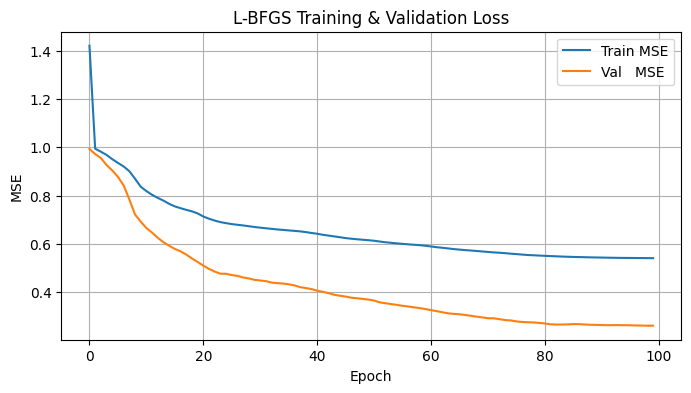

In [ ]:
"""
L-BFGS Optimisation with Optuna for Feed-Forward Neural Network Training
=========================================================================

This script implements hyperparameter optimisation for training a Feed-Forward Neural Network (FFN)
using the Limited-memory BFGS (L-BFGS) algorithm. It is designed as part of a comparative study of
SGD, L-BFGS, and Genetic Algorithms on a multimodal loss landscape, as specified in the project brief.

The workflow includes:
1. Model architecture setup using a fixed Optuna-tuned FFN configuration.
2. Weight initialisation using configurable schemes (Xavier, Kaiming).
3. L-BFGS hyperparameter tuning via Optuna over learning rate, max_iter, and training epochs.
4. Final retraining of the best model with loss curves plotted for visual comparison.
5. Exposure of the trained model and hyperparameters for downstream use.

Instructions for Use
---------------------
- Ensure that `X_train`, `y_train`, `X_val`, and `y_val` tensors are pre-defined in your workspace.
- Execute this script after defining these tensors to perform L-BFGS hyperparameter search and training.
- Modify `arch_params` and `init_scheme` to experiment with different FFN configurations.
- Adjust the Optuna search space within `objective()` for further tuning.

Changing the Architecture
--------------------------
- The FFN architecture is defined by `arch_params`, which controls the number of layers, units per layer,
  and activation function. Only standard PyTorch activations (e.g., "ReLU", "Tanh") are supported.
- To change the architecture, update `arch_params` accordingly.

Changing the Initialisation Scheme
-----------------------------------
- Set `init_scheme` to one of: 'xavier_normal', 'xavier_uniform', 'kaiming_normal', or 'kaiming_uniform'.

Customising the Optuna Search
------------------------------
- The `objective()` function defines the search space:
    * `lr`: Learning rate (log-uniform)
    * `max_iter`: L-BFGS internal iterations per outer step
    * `epochs`: Total number of epochs to run optimizer.step()
- Modify the ranges or add new parameters as needed.

Outputs
-------
- Prints the best hyperparameters and validation MSE.
- Plots training and validation MSE curves.
- Exposes:
    * `best_model_lbfgs`: trained FFN model
    * `best_params_lbfgs`: dictionary of best Optuna hyperparameters

"""

#  L-BFGS + Optuna Hyperparameter Search on Best FFN Architecture
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import optuna
import torch.nn.init as init

# 1) Device
device = torch.device("cpu")

# 2) Move data to device
X_train_dev = X_train.to(device)
y_train_dev = y_train.to(device)
X_val_dev   = X_val.to(device)
y_val_dev   = y_val.to(device)

# 3) Best FFN architecture from Optuna + init scheme
arch_params = {
    "n_layers":   2,
    "n_units":    24,
    "activation": "ReLU"
}
init_scheme = "xavier_normal"
def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if init_scheme == 'xavier_normal':
                init.xavier_normal_(layer.weight)
            elif init_scheme == 'xavier_uniform':
                init.xavier_uniform_(layer.weight)
            elif init_scheme == 'kaiming_normal':
                init.kaiming_normal_(layer.weight, nonlinearity='relu')
            elif init_scheme == 'kaiming_uniform':
                init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

def build_model():
    layers = []
    in_f = X_train_dev.shape[1]
    Act  = getattr(nn, arch_params["activation"])
    for _ in range(arch_params["n_layers"]):
        layers += [nn.Linear(in_f, arch_params["n_units"]), Act()]
        in_f = arch_params["n_units"]
    layers.append(nn.Linear(in_f, 1))
    model = nn.Sequential(*layers).to(device)
    initialize_weights(model)
    return model

# 4) Optuna objective
def objective(trial):
    lr       = trial.suggest_loguniform("lr",      1e-2, 10.0)
    max_iter = trial.suggest_categorical("max_iter", [10, 20, 50])
    epochs   = trial.suggest_int("epochs", 20, 100, step=20)
    
    model     = build_model()
    criterion = nn.MSELoss()
    optimizer = optim.LBFGS(model.parameters(), lr=lr, max_iter=max_iter)
    
    train_losses, val_losses = [], []
    for _ in range(epochs):
        def closure():
            optimizer.zero_grad()
            out = model(X_train_dev)
            loss = criterion(out, y_train_dev)
            loss.backward()
            return loss
        train_loss = optimizer.step(closure)
        train_losses.append(train_loss.item())
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_val_dev), y_val_dev).item()
        val_losses.append(val_loss)
    # report final validation loss
    return val_losses[-1]

# 5) Run the search
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

# 6) Retrieve best hyperparameters
best = study.best_trial
print("\n Best L-BFGS Config:")
for k,v in best.params.items():
    print(f"  {k}: {v}")
print(f"Best Validation MSE: {best.value:.5f}\n")

# 7) Re-train best model to record curves
best_lr       = best.params["lr"]
best_max_iter = best.params["max_iter"]
best_epochs   = best.params["epochs"]
model     = build_model()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr=best_lr, max_iter=best_max_iter)
train_losses, val_losses = [], []
for epoch in range(1, best_epochs+1):
    def closure():
        optimizer.zero_grad()
        out = model(X_train_dev)
        loss = criterion(out, y_train_dev)
        loss.backward()
        return loss
    train_loss = optimizer.step(closure)
    train_losses.append(train_loss.item())
    model.eval()
    with torch.no_grad():
        val_losses.append(criterion(model(X_val_dev), y_val_dev).item())
    if epoch % (best_epochs // 5) == 0 or epoch == 1:
        print(f"Epoch {epoch}/{best_epochs} ▶ train MSE: {train_losses[-1]:.4f}, val MSE: {val_losses[-1]:.4f}")
print("\n✅ Final L-BFGS training complete!")

# 8) Plot the loss curves
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses,   label="Val   MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("L-BFGS Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# 9) Expose best model & params for downstream use
best_model_lbfgs = model
best_params_lbfgs = best.params


#### LBFGS run using parameters found with optuna: 

Using device: cuda

Epoch   1/100 ▶ train MSE: 1.0225, val MSE: 0.9938
Epoch  20/100 ▶ train MSE: 0.7566, val MSE: 0.5818
Epoch  40/100 ▶ train MSE: 0.6345, val MSE: 0.4083
Epoch  60/100 ▶ train MSE: 0.6128, val MSE: 0.3795
Epoch  80/100 ▶ train MSE: 0.5997, val MSE: 0.3634
Epoch 100/100 ▶ train MSE: 0.5949, val MSE: 0.3593

✅ L-BFGS training complete!


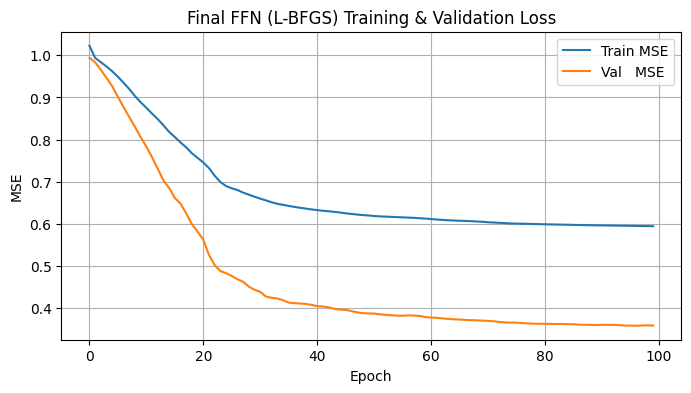


✅ L-BFGS–trained model and metadata saved to `checkpoints_lbfgs/`


In [ ]:
"""
Final L-BFGS Training and Checkpointing for Feed-Forward Neural Network
========================================================================

This script performs final training of a Feed-Forward Neural Network (FFN)
using the L-BFGS optimiser with previously tuned hyperparameters, logs
training and validation losses, and saves the model weights and metadata
for downstream use.

Modules Used:
-------------
- PyTorch (`torch`, `torch.nn`, `torch.optim`)
- Matplotlib for loss visualization
- NumPy and JSON for checkpoint management

Workflow Overview:
------------------
1. Load preprocessed training and validation tensors (`X_train`, `y_train`, `X_val`, `y_val`).
2. Define and build the FFN architecture using saved best parameters.
3. Initialise the L-BFGS optimiser with the tuned hyperparameters.
4. Train the model using full-batch L-BFGS over multiple epochs.
5. Log epoch duration, train MSE, and validation MSE to a CSV file (`lbfgs_stats.csv`).
6. Plot loss curves and save figure (optional extension).
7. Save:
   - model weights (`.pth`)
   - final genome as flat parameter vector (`.npy`)
   - full metadata (`.json`) for reproducibility.

How to Use:
-----------
- Ensure your data tensors (`X_train`, `y_train`, `X_val`, `y_val`) are defined beforehand.
- Adjust `arch_params` or `best_lbfgs` dictionaries to use different model configurations or hyperparameters.
- This script automatically logs results and saves model checkpoints to `checkpoints_lbfgs/`.

Outputs:
--------
- `lbfgs_stats.csv`: MSE log per epoch
- `checkpoints_lbfgs/lbfgs_final_weights.pth`: Final model weights
- `checkpoints_lbfgs/lbfgs_final_genome.npy`: Flat parameter vector
- `checkpoints_lbfgs/lbfgs_model_meta.json`: JSON metadata (architecture + optimiser params)
- Final loss curves plotted using Matplotlib

Notes:
------
- This script assumes full-batch training (i.e., L-BFGS is called once per epoch).
- Make sure the GPU is available and accessible via `torch.cuda.is_available()`; otherwise, CPU will be used.
- Can be extended to include test-set evaluation using the trained model.

"""

import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os, json, numpy as np
from torch.nn.utils import parameters_to_vector

# 1) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

# 2) Best FFN architecture (from Optuna) + your L-BFGS hyperparams
arch_params = {
    "n_layers":   2,
    "n_units":    24,
    "activation": "ReLU"
}
best_lbfgs = {
    "lr":       0.9669461523303573,
    "max_iter": 20,
    "epochs":   100
}

# 3) Move data to device
X_tr, y_tr = X_train.to(device), y_train.to(device)
X_v,  y_v  = X_val.to(device),   y_val.to(device)

# 4) Build the model
layers = []
in_f   = X_tr.shape[1]
Act    = getattr(nn, arch_params["activation"])
for _ in range(arch_params["n_layers"]):
    layers += [nn.Linear(in_f, arch_params["n_units"]), Act()]
    in_f    = arch_params["n_units"]
layers.append(nn.Linear(in_f, 1))
model = nn.Sequential(*layers).to(device)

# 5) Optimizer & loss
optimizer = optim.LBFGS(
    model.parameters(),
    lr=best_lbfgs["lr"],
    max_iter=best_lbfgs["max_iter"]
)
criterion = nn.MSELoss()

# 6) Prepare L-BFGS log file
LOG_FN = "lbfgs_stats.csv"
with open(LOG_FN, "w") as f:
    f.write("epoch,epoch_time,train_mse,val_mse\n")

# 6) Train for N full-batch epochs
epochs       = best_lbfgs["epochs"]
train_losses = []
val_losses   = []

for epoch in range(1, epochs+1):
    start_time = time.time()
    def closure():
        optimizer.zero_grad()
        out  = model(X_tr)
        loss = criterion(out, y_tr)
        loss.backward()
        return loss
    # one L-BFGS step
    train_loss = optimizer.step(closure)
    train_losses.append(train_loss.item())
    # eval on validation set
    model.eval()
    with torch.no_grad():
        val_mse = criterion(model(X_v), y_v).item()
    val_losses.append(val_mse)
    model.train()
    epoch_time = time.time() - start_time
    # append to CSV
    with open(LOG_FN, "a") as f:
        f.write(f"{epoch},{epoch_time:.6f},{train_losses[-1]:.6f},{val_mse:.6f}\n")
    if epoch == 1 or epoch % 20 == 0:
        print(f"Epoch {epoch:3d}/{epochs} ▶ train MSE: {train_losses[-1]:.4f}, val MSE: {val_losses[-1]:.4f}")
print("\n✅ L-BFGS training complete!")

# 7) Plot curves
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses,   label="Val   MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Final FFN (L-BFGS) Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

#  Save final L-BFGS–trained model 
os.makedirs("checkpoints_lbfgs", exist_ok=True)

# 1) Save the PyTorch state_dict
torch.save(
    model.state_dict(),
    "checkpoints_lbfgs/lbfgs_final_weights.pth"
)

# 2) Save the flat parameter vector
genome_lbfgs = parameters_to_vector(model.parameters()).detach().cpu().numpy()
np.save(
    "checkpoints_lbfgs/lbfgs_final_genome.npy",
    genome_lbfgs
)

# 3) Save the architecture & L-BFGS hyperparams so you can rebuild later
meta_lbfgs = {
    "arch": arch_params,      # your {"n_layers":…, "n_units":…, "activation":…}
    "lbfgs_params": best_lbfgs # your {"lr":…, "max_iter":…, "epochs":…}
}
with open("checkpoints_lbfgs/lbfgs_model_meta.json", "w") as fp:
    json.dump(meta_lbfgs, fp, indent=2)

print("\n✅ L-BFGS–trained model and metadata saved to `checkpoints_lbfgs/`")


#### Vanilla GA: First reasonably successful implementation:

Using device: cuda

Gen  1/2000 ▶ train MSE: 1.0086, val MSE: 1.0063
Gen 100/2000 ▶ train MSE: 0.9933, val MSE: 0.9912
Gen 200/2000 ▶ train MSE: 0.9892, val MSE: 0.9848
Gen 300/2000 ▶ train MSE: 0.9840, val MSE: 0.9778
Gen 400/2000 ▶ train MSE: 0.9783, val MSE: 0.9704
Gen 500/2000 ▶ train MSE: 0.9736, val MSE: 0.9633
Gen 600/2000 ▶ train MSE: 0.9697, val MSE: 0.9576
Gen 700/2000 ▶ train MSE: 0.9661, val MSE: 0.9520
Gen 800/2000 ▶ train MSE: 0.9629, val MSE: 0.9459
Gen 900/2000 ▶ train MSE: 0.9605, val MSE: 0.9425
Gen 1000/2000 ▶ train MSE: 0.9582, val MSE: 0.9379
Gen 1100/2000 ▶ train MSE: 0.9561, val MSE: 0.9344
Gen 1200/2000 ▶ train MSE: 0.9541, val MSE: 0.9314
Gen 1300/2000 ▶ train MSE: 0.9513, val MSE: 0.9272
Gen 1400/2000 ▶ train MSE: 0.9486, val MSE: 0.9223
Gen 1500/2000 ▶ train MSE: 0.9459, val MSE: 0.9175
Gen 1600/2000 ▶ train MSE: 0.9430, val MSE: 0.9129
Gen 1700/2000 ▶ train MSE: 0.9401, val MSE: 0.9082
Gen 1800/2000 ▶ train MSE: 0.9375, val MSE: 0.9038
Gen 1900/2000 ▶ train 

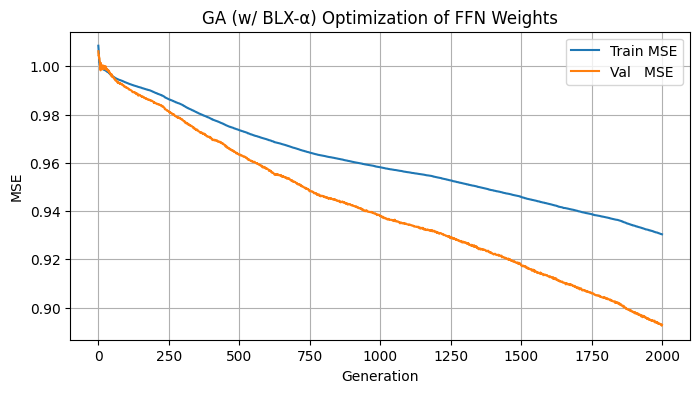

In [ ]:
"""
Genetic Algorithm (GA) for Optimising Feed-Forward Neural Network Weights
==========================================================================

This script implements a real-valued Genetic Algorithm (GA) using Blend Crossover (BLX-α)
and Gaussian mutation to optimise the parameters of a fixed-architecture feed-forward
neural network (FFN). The algorithm is applied to a regression task with MSE loss, and
performance is tracked across generations.

Key Features:
-------------
- Fixed FFN architecture using PyTorch with Xavier weight initialisation
- Real-valued genome representation using PyTorch parameter vectors
- Tournament selection (size = 3) with elitism (top 20% retained each generation)
- BLX-α crossover with α = 0.3 for diversity-preserving recombination
- Gaussian mutation applied per gene with probability `mutation_p` and std dev `mutation_sd`
- Reproducible results via fixed seeds for NumPy and PyTorch
- Final best model reconstructed and evaluated
- MSE loss curves plotted across generations

Instructions:
-------------
1. Ensure that `X_train`, `y_train`, `X_val`, and `y_val` are defined as PyTorch tensors.
2. Adjust architecture via the `arch` dictionary.
3. Modify genetic algorithm hyperparameters (e.g., `pop_size`, `generations`, `mutation_p`) as needed.
4. Run the script to execute the full evolutionary cycle and view results.

Hyperparameters:
----------------
- `pop_size`: Number of individuals in the population
- `generations`: Number of generations to evolve
- `elite_frac`: Proportion of top individuals carried over each generation
- `tourn_size`: Tournament size for selection
- `mutation_p`: Probability of mutating each gene
- `mutation_sd`: Standard deviation of mutation noise
- `blx_alpha`: BLX-α parameter controlling crossover range

Outputs:
--------
- Printed train/validation MSE every 100 generations
- Final best model with evaluation on training and validation sets
- Plot of training and validation MSE vs. generation
- Internal genome evolution stored in memory only (can be extended to save)


"""
import sklearn.decomposition as skPCA
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt
import torch.nn.init as init
#  Repro & Device
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")
# Data to device
X_train_dev, y_train_dev = X_train.to(device), y_train.to(device)
X_val_dev,   y_val_dev   = X_val.to(device),   y_val.to(device)
#   Fixed Architecture + Xavier init 
arch = dict(n_layers=2, n_units=24, activation="ReLU")
init_scheme = "xavier_normal"
criterion   = nn.MSELoss()
def build_model():
    layers, in_f = [], X_train_dev.shape[1]
    Act = getattr(nn, arch["activation"])
    for _ in range(arch["n_layers"]):
        layers += [nn.Linear(in_f, arch["n_units"]), Act()]
        in_f = arch["n_units"]
    layers.append(nn.Linear(in_f,1))
    m = nn.Sequential(*layers).to(device)
    for L in m.modules():
        if isinstance(L, nn.Linear):
            init.xavier_normal_(L.weight)
    return m

#  GA Hyperparams
pop_size    = 200
generations = 2000
elite_frac  = 0.1
tourn_size  = 3
mutation_p  = 0.01
mutation_sd = 0.01
blx_alpha   = 0.3  

#  Init Population
pop = []
for _ in range(pop_size):
    m = build_model()
    vec = parameters_to_vector(m.parameters()).detach().cpu().numpy().astype(np.float32)
    pop.append(vec)

# visualize initial population 
pop_mat = np.stack(pop)          
genome_len = pop[0].size
#  5) Tournament Selection
def tournament_select(pop, fitness):
    idxs = np.random.choice(pop_size, tourn_size, replace=False)
    best = idxs[np.argmin([fitness[i] for i in idxs])]
    return pop[best]
#  6) Evolution 
train_curve = []
val_curve   = []
best_norms = []
for gen in range(1, generations+1):
    # Fitness eval
    fitness = []
    for genome in pop:
        m = build_model()
        vector_to_parameters(torch.from_numpy(genome).to(device), m.parameters())
        with torch.no_grad():
            fitness.append(criterion(m(X_train_dev), y_train_dev).item())
    f = np.array(fitness)
    # record best
    best_idx = int(np.argmin(fitness))
    #Diagnostic code
    best_gen   = pop[best_idx]
    norm_best  = np.linalg.norm(best_gen)
    best_norms.append(norm_best)
    prev_best_gen = best_gen.copy()
    tr_mse   = fitness[best_idx]
    m_best   = build_model()
    vector_to_parameters(torch.from_numpy(pop[best_idx]).to(device), m_best.parameters())
    with torch.no_grad():
        va_mse = criterion(m_best(X_val_dev), y_val_dev).item()
    train_curve.append(tr_mse)
    val_curve.append(va_mse)
    if gen == 1 or gen % 100 == 0:
        print(f"Gen {gen:2d}/{generations} ▶ train MSE: {tr_mse:.4f}, val MSE: {va_mse:.4f}")
    #  Elitism
    elite_n = max(1, int(elite_frac * pop_size))
    elites  = [pop[i] for i in np.argsort(fitness)[:elite_n]]
    pop_size   = len(pop)
    elite_frac = 0.2            
    elite_n    = max(1, int(elite_frac * pop_size))
    elite_idxs = np.argsort(fitness)[:elite_n]
    elites     = [pop[i] for i in elite_idxs]
    # selection probabilities
    p_elite   = 0
    p_tourn   = 1
    # p_random = 0.1  # implicit: 1 - (p_elite + p_tourn)
    def sample_parent(pop, fitness):
        if (p_elite == 0 and p_tourn == 1):
            # pure tournament selection
            return tournament_select(pop, fitness)
        if (p_elite == 1 and p_tourn == 0):
            # pure elitism
            return elites[np.random.randint(elite_n)]
        r = np.random.rand()
        if r < p_elite:
            # exploit: uniform from elites
            return elites[np.random.randint(elite_n)]
        elif r < p_elite + p_tourn:
            # competition: standard tournament over full pop
            return tournament_select(pop, fitness)
        else:
            # pure exploration: uniform from entire pop
            return pop[np.random.randint(pop_size)]
    #  Reproduce via BLX-α + mutation
    new_pop = elites.copy()
    while len(new_pop) < pop_size:
        p1 = sample_parent(pop, fitness)
        p2 = sample_parent(pop, fitness)
        # BLX-α crossover
        low  = np.minimum(p1,p2) - blx_alpha * np.abs(p1-p2)
        high = np.maximum(p1,p2) + blx_alpha * np.abs(p1-p2)
        child = np.random.uniform(low, high).astype(np.float32)
        # mutation
        mask  = np.random.rand(genome_len) < mutation_p
        noise = np.random.randn(genome_len).astype(np.float32) * mutation_sd
        child[mask] += noise[mask]
        new_pop.append(child)
    pop = new_pop
# ─── 7) Final Best Model ───────────────────────────────────────────────────────
best_genome = pop[int(np.argmin(fitness))]
best_model_ga = build_model()
vector_to_parameters(torch.from_numpy(best_genome).to(device),
                     best_model_ga.parameters())
best_model_ga.eval()
with torch.no_grad():
    final_tr = criterion(best_model_ga(X_train_dev), y_train_dev).item()
    final_va = criterion(best_model_ga(X_val_dev),   y_val_dev).item()
print(f"\n✅ GA done!  Final Train MSE: {final_tr:.4f}, Val MSE: {final_va:.4f}")
# 8) Plot 
plt.figure(figsize=(8,4))
plt.plot(train_curve, label="Train MSE")
plt.plot(val_curve,   label="Val   MSE")
plt.xlabel("Generation")
plt.ylabel("MSE")
plt.title("GA (w/ BLX-α) Optimization of FFN Weights")
plt.legend()
plt.grid(True)
plt.show()


#### Same GA implementation: Changing alpha value for blx crossover from 0.3 to 0.5:

Using device: cuda

Gen  1/2000 ▶ train MSE: 0.9623, val MSE: 0.9498
Gen  1/2000 ▶ train MSE: 1.0086, val MSE: 1.0063
Gen  2/2000 ▶ train MSE: 1.0086, val MSE: 1.0063
Gen  3/2000 ▶ train MSE: 1.0086, val MSE: 1.0063
Gen  4/2000 ▶ train MSE: 1.0086, val MSE: 1.0063
Gen  5/2000 ▶ train MSE: 1.0086, val MSE: 1.0063
Gen  6/2000 ▶ train MSE: 1.0086, val MSE: 1.0063
Gen  7/2000 ▶ train MSE: 1.0086, val MSE: 1.0063
Gen  8/2000 ▶ train MSE: 1.0086, val MSE: 1.0063
Gen  9/2000 ▶ train MSE: 1.0086, val MSE: 1.0063
Gen 10/2000 ▶ train MSE: 1.0086, val MSE: 1.0063
Gen 11/2000 ▶ train MSE: 1.0080, val MSE: 1.0096
Gen 12/2000 ▶ train MSE: 1.0080, val MSE: 1.0096
Gen 13/2000 ▶ train MSE: 1.0080, val MSE: 1.0096
Gen 14/2000 ▶ train MSE: 1.0047, val MSE: 1.0029
Gen 15/2000 ▶ train MSE: 1.0047, val MSE: 1.0029
Gen 16/2000 ▶ train MSE: 1.0047, val MSE: 1.0029
Gen 17/2000 ▶ train MSE: 1.0047, val MSE: 1.0029
Gen 18/2000 ▶ train MSE: 1.0047, val MSE: 1.0029
Gen 19/2000 ▶ train MSE: 1.0047, val MSE: 1.0029


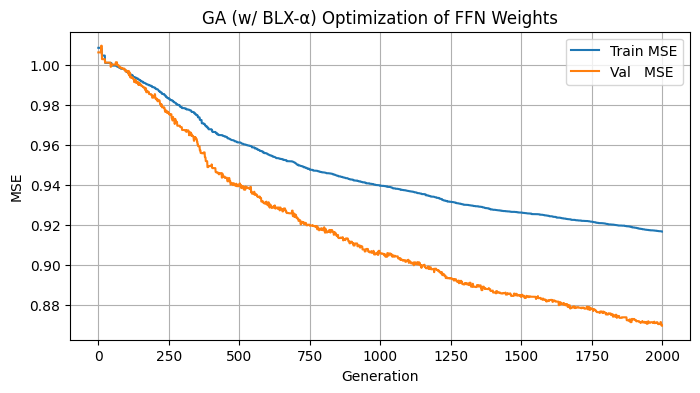

In [ ]:
"""
Genetic Algorithm (GA) for Optimising Feed-Forward Neural Network Weights
==========================================================================

This script implements a real-valued Genetic Algorithm (GA) using Blend Crossover (BLX-α)
and Gaussian mutation to optimise the parameters of a fixed-architecture feed-forward
neural network (FFN). The algorithm is applied to a regression task with MSE loss, and
performance is tracked across generations.

Key Features:
-------------
- Fixed FFN architecture using PyTorch with Xavier weight initialisation
- Real-valued genome representation using PyTorch parameter vectors
- Tournament selection (size = 3) with elitism (top 20% retained each generation)
- BLX-α crossover with α = 0.5 for diversity-preserving recombination
- Gaussian mutation applied per gene with probability `mutation_p` and std dev `mutation_sd`
- Reproducible results via fixed seeds for NumPy and PyTorch
- Final best model reconstructed and evaluated
- MSE loss curves plotted across generations

Instructions:
-------------
1. Ensure that `X_train`, `y_train`, `X_val`, and `y_val` are defined as PyTorch tensors.
2. Adjust architecture via the `arch` dictionary.
3. Modify genetic algorithm hyperparameters (e.g., `pop_size`, `generations`, `mutation_p`) as needed.
4. Run the script to execute the full evolutionary cycle and view results.

Hyperparameters:
----------------
- `pop_size`: Number of individuals in the population
- `generations`: Number of generations to evolve
- `elite_frac`: Proportion of top individuals carried over each generation
- `tourn_size`: Tournament size for selection
- `mutation_p`: Probability of mutating each gene
- `mutation_sd`: Standard deviation of mutation noise
- `blx_alpha`: BLX-α parameter controlling crossover range

Outputs:
--------
- Printed train/validation MSE every 100 generations
- Final best model with evaluation on training and validation sets
- Plot of training and validation MSE vs. generation
- Internal genome evolution stored in memory only (can be extended to save)


"""

import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt
import torch.nn.init as init
import sklearn.decomposition as skPCA

#  0) Repro & Device 
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

#  1) Data to device 
X_train_dev, y_train_dev = X_train.to(device), y_train.to(device)
X_val_dev,   y_val_dev   = X_val.to(device),   y_val.to(device)
#  2) Fixed Architecture + Xavier init 
arch = dict(n_layers=2, n_units=24, activation="ReLU")
init_scheme = "xavier_normal"
criterion   = nn.MSELoss()
def build_model():
    layers, in_f = [], X_train_dev.shape[1]
    Act = getattr(nn, arch["activation"])
    for _ in range(arch["n_layers"]):
        layers += [nn.Linear(in_f, arch["n_units"]), Act()]
        in_f = arch["n_units"]
    layers.append(nn.Linear(in_f,1))
    m = nn.Sequential(*layers).to(device)
    for L in m.modules():
        if isinstance(L, nn.Linear):
            init.xavier_normal_(L.weight)
    return m

#  3) GA Hyperparams 
pop_size    = 200
generations = 2000
elite_frac  = 0.1
tourn_size  = 3
mutation_p  = 0.01
mutation_sd = 0.01
blx_alpha   = 0.5  

#  4) Init Population 
pop = []
for _ in range(pop_size):
    m = build_model()
    vec = parameters_to_vector(m.parameters()).detach().cpu().numpy().astype(np.float32)
    pop.append(vec)

#  visualize initial population 
pop_mat = np.stack(pop)          
genome_len = pop[0].size

#  5) Tournament Selection 
def tournament_select(pop, fitness):
    idxs = np.random.choice(pop_size, tourn_size, replace=False)
    best = idxs[np.argmin([fitness[i] for i in idxs])]
    return pop[best]
#  6) Evolution 
train_curve = []
val_curve   = []
best_norms = []
for gen in range(1, generations+1):
    # a) Fitness eval
    fitness = []
    for genome in pop:
        m = build_model()
        vector_to_parameters(torch.from_numpy(genome).to(device), m.parameters())
        with torch.no_grad():
            fitness.append(criterion(m(X_train_dev), y_train_dev).item())
    f = np.array(fitness)
    if gen == 1 or gen % 100 == 0:
        print(f"Gen {gen:2d}/{generations} ▶ train MSE: {tr_mse:.4f}, val MSE: {va_mse:.4f}")
    # record best
    best_idx = int(np.argmin(fitness))
    tr_mse   = fitness[best_idx]
    m_best   = build_model()
    vector_to_parameters(torch.from_numpy(pop[best_idx]).to(device), m_best.parameters())
    with torch.no_grad():
        va_mse = criterion(m_best(X_val_dev), y_val_dev).item()
    train_curve.append(tr_mse)
    val_curve.append(va_mse)
    print(f"Gen {gen:2d}/{generations} ▶ train MSE: {tr_mse:.4f}, val MSE: {va_mse:.4f}")
    # Elitism
    elite_n = max(1, int(elite_frac * pop_size))
    elites  = [pop[i] for i in np.argsort(fitness)[:elite_n]]
    pop_size   = len(pop)
    elite_frac = 0.2             
    elite_n    = max(1, int(elite_frac * pop_size))
    elite_idxs = np.argsort(fitness)[:elite_n]
    elites     = [pop[i] for i in elite_idxs]
    # selection probabilities
    p_elite   = 0
    p_tourn   = 1
    # p_random = 0.1  # implicit: 1 - (p_elite + p_tourn)

    def sample_parent(pop, fitness):
        if (p_elite == 0 and p_tourn == 1):
            # pure tournament selection
            return tournament_select(pop, fitness)
        if (p_elite == 1 and p_tourn == 0):
            # pure elitism
            return elites[np.random.randint(elite_n)]
        r = np.random.rand()
        if r < p_elite:
            # exploit: uniform from elites
            return elites[np.random.randint(elite_n)]
        elif r < p_elite + p_tourn:
            # competition: standard tournament over full pop
            return tournament_select(pop, fitness)
        else:
            # pure exploration: uniform from entire pop
            return pop[np.random.randint(pop_size)]
    # c) Reproduce via BLX-α + mutation
    new_pop = elites.copy()
    while len(new_pop) < pop_size:
        p1 = sample_parent(pop, fitness)
        p2 = sample_parent(pop, fitness)
        # BLX-α crossover
        low  = np.minimum(p1,p2) - blx_alpha * np.abs(p1-p2)
        high = np.maximum(p1,p2) + blx_alpha * np.abs(p1-p2)
        child = np.random.uniform(low, high).astype(np.float32)
        # mutation applied
        mask  = np.random.rand(genome_len) < mutation_p
        noise = np.random.randn(genome_len).astype(np.float32) * mutation_sd
        child[mask] += noise[mask]
        new_pop.append(child)
    pop = new_pop
#  7) Final Best Model 
best_genome = pop[int(np.argmin(fitness))]
best_model_ga = build_model()
vector_to_parameters(torch.from_numpy(best_genome).to(device),
                     best_model_ga.parameters())
best_model_ga.eval()
with torch.no_grad():
    final_tr = criterion(best_model_ga(X_train_dev), y_train_dev).item()
    final_va = criterion(best_model_ga(X_val_dev),   y_val_dev).item()
print(f"\n✅ GA done!  Final Train MSE: {final_tr:.4f}, Val MSE: {final_va:.4f}")
#  8) Plot 
plt.figure(figsize=(8,4))
plt.plot(train_curve, label="Train MSE")
plt.plot(val_curve,   label="Val   MSE")
plt.xlabel("Generation")
plt.ylabel("MSE")
plt.title("GA (w/ BLX-α) Optimization of FFN Weights")
plt.legend()
plt.grid(True)
plt.show()


#### Same implementation, increasing blx alpha to 0.6:

Using device: cuda

Gen  1/2000 ▶ train MSE: 0.9968, val MSE: 0.9961
Gen 100/2000 ▶ train MSE: 0.9953, val MSE: 0.9951
Gen 200/2000 ▶ train MSE: 0.9900, val MSE: 0.9884
Gen 300/2000 ▶ train MSE: 0.9811, val MSE: 0.9770
Gen 400/2000 ▶ train MSE: 0.9740, val MSE: 0.9669
Gen 500/2000 ▶ train MSE: 0.9679, val MSE: 0.9572
Gen 600/2000 ▶ train MSE: 0.9633, val MSE: 0.9498
Gen 700/2000 ▶ train MSE: 0.9552, val MSE: 0.9367
Gen 800/2000 ▶ train MSE: 0.9498, val MSE: 0.9307
Gen 900/2000 ▶ train MSE: 0.9447, val MSE: 0.9225
Gen 1000/2000 ▶ train MSE: 0.9416, val MSE: 0.9181
Gen 1100/2000 ▶ train MSE: 0.9356, val MSE: 0.9080
Gen 1200/2000 ▶ train MSE: 0.9291, val MSE: 0.8976
Gen 1300/2000 ▶ train MSE: 0.9222, val MSE: 0.8861
Gen 1400/2000 ▶ train MSE: 0.9191, val MSE: 0.8826
Gen 1500/2000 ▶ train MSE: 0.9120, val MSE: 0.8672
Gen 1600/2000 ▶ train MSE: 0.9067, val MSE: 0.8601
Gen 1700/2000 ▶ train MSE: 0.9005, val MSE: 0.8491
Gen 1800/2000 ▶ train MSE: 0.8963, val MSE: 0.8416
Gen 1900/2000 ▶ train 

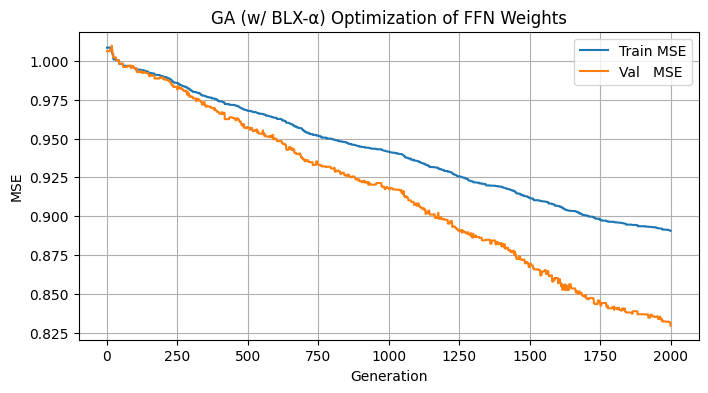

In [ ]:
"""
Genetic Algorithm (GA) for Optimising Feed-Forward Neural Network Weights
==========================================================================

This script implements a real-valued Genetic Algorithm (GA) using Blend Crossover (BLX-α)
and Gaussian mutation to optimise the parameters of a fixed-architecture feed-forward
neural network (FFN). The algorithm is applied to a regression task with MSE loss, and
performance is tracked across generations.

Key Features:
-------------
- Fixed FFN architecture using PyTorch with Xavier weight initialisation
- Real-valued genome representation using PyTorch parameter vectors
- Tournament selection (size = 3) with elitism (top 10% retained each generation)
- BLX-α crossover with α = 0.6 for diversity-preserving recombination
- Gaussian mutation applied per gene with probability `mutation_p` and std dev `mutation_sd`
- Reproducible results via fixed seeds for NumPy and PyTorch
- Final best model reconstructed and evaluated
- MSE loss curves plotted across generations

Instructions:
-------------
1. Ensure that `X_train`, `y_train`, `X_val`, and `y_val` are defined as PyTorch tensors.
2. Adjust architecture via the `arch` dictionary.
3. Modify genetic algorithm hyperparameters (e.g., `pop_size`, `generations`, `mutation_p`) as needed.
4. Run the script to execute the full evolutionary cycle and view results.

Hyperparameters:
----------------
- `pop_size`: Number of individuals in the population
- `generations`: Number of generations to evolve
- `elite_frac`: Proportion of top individuals carried over each generation
- `tourn_size`: Tournament size for selection
- `mutation_p`: Probability of mutating each gene
- `mutation_sd`: Standard deviation of mutation noise
- `blx_alpha`: BLX-α parameter controlling crossover range

Outputs:
--------
- Printed train/validation MSE every 100 generations
- Final best model with evaluation on training and validation sets
- Plot of training and validation MSE vs. generation
- Internal genome evolution stored in memory only (can be extended to save)

"""

import sklearn.decomposition as skPCA
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt
import torch.nn.init as init

#  0) Repro & Device 
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")
# ─── 1) Data to device 
X_train_dev, y_train_dev = X_train.to(device), y_train.to(device)
X_val_dev,   y_val_dev   = X_val.to(device),   y_val.to(device)
# ─── 2) Fixed Architecture + Xavier init 
arch = dict(n_layers=2, n_units=24, activation="ReLU")
init_scheme = "xavier_normal"
criterion   = nn.MSELoss()
def build_model():
    layers, in_f = [], X_train_dev.shape[1]
    Act = getattr(nn, arch["activation"])
    for _ in range(arch["n_layers"]):
        layers += [nn.Linear(in_f, arch["n_units"]), Act()]
        in_f = arch["n_units"]
    layers.append(nn.Linear(in_f,1))
    m = nn.Sequential(*layers).to(device)
    for L in m.modules():
        if isinstance(L, nn.Linear):
            init.xavier_normal_(L.weight)
    return m
#  3) GA Hyperparams 
pop_size    = 200
generations = 2000
elite_frac  = 0.1
tourn_size  = 3
mutation_p  = 0.01
mutation_sd = 0.01
blx_alpha   = 0.6

#  4) Init Population 
pop = []
for _ in range(pop_size):
    m = build_model()
    vec = parameters_to_vector(m.parameters()).detach().cpu().numpy().astype(np.float32)
    pop.append(vec)
#  visualize initial population 
pop_mat = np.stack(pop)           
genome_len = pop[0].size
#  5) Tournament Selection 
def tournament_select(pop, fitness):
    idxs = np.random.choice(pop_size, tourn_size, replace=False)
    best = idxs[np.argmin([fitness[i] for i in idxs])]
    return pop[best]
#  6) Evolution 
train_curve = []
val_curve   = []
best_norms = []
for gen in range(1, generations+1):
    #  Fitness eval
    fitness = []
    for genome in pop:
        m = build_model()
        vector_to_parameters(torch.from_numpy(genome).to(device), m.parameters())
        with torch.no_grad():
            fitness.append(criterion(m(X_train_dev), y_train_dev).item())
    f = np.array(fitness)
    if gen == 1 or gen % 100 == 0:
        print(f"Gen {gen:2d}/{generations} ▶ train MSE: {tr_mse:.4f}, val MSE: {va_mse:.4f}")
    # record best
    best_idx = int(np.argmin(fitness))
    tr_mse   = fitness[best_idx]
    m_best   = build_model()
    vector_to_parameters(torch.from_numpy(pop[best_idx]).to(device), m_best.parameters())
    with torch.no_grad():
        va_mse = criterion(m_best(X_val_dev), y_val_dev).item()
    train_curve.append(tr_mse)
    val_curve.append(va_mse)
    # b) Elitism
    elite_n = max(1, int(elite_frac * pop_size))
    elites  = [pop[i] for i in np.argsort(fitness)[:elite_n]]
    pop_size   = len(pop)
    elite_frac = 0.2           
    elite_n    = max(1, int(elite_frac * pop_size))
    elite_idxs = np.argsort(fitness)[:elite_n]
    elites     = [pop[i] for i in elite_idxs]
    # selection probabilities
    p_elite   = 0
    p_tourn   = 1
    def sample_parent(pop, fitness):
        if (p_elite == 0 and p_tourn == 1):
            # pure tournament selection
            return tournament_select(pop, fitness)
        if (p_elite == 1 and p_tourn == 0):
            # pure elitism
            return elites[np.random.randint(elite_n)]
        r = np.random.rand()
        if r < p_elite:
            # exploit: uniform from elites
            return elites[np.random.randint(elite_n)]
        elif r < p_elite + p_tourn:
            # competition: standard tournament over full pop
            return tournament_select(pop, fitness)
        else:
            # pure exploration: uniform from entire pop
            return pop[np.random.randint(pop_size)]
    # c) Reproduce via BLX-α + mutation
    new_pop = elites.copy()
    while len(new_pop) < pop_size:
        p1 = sample_parent(pop, fitness)
        p2 = sample_parent(pop, fitness)
        # BLX-α crossover
        low  = np.minimum(p1,p2) - blx_alpha * np.abs(p1-p2)
        high = np.maximum(p1,p2) + blx_alpha * np.abs(p1-p2)
        child = np.random.uniform(low, high).astype(np.float32)
        # mutation
        mask  = np.random.rand(genome_len) < mutation_p
        noise = np.random.randn(genome_len).astype(np.float32) * mutation_sd
        child[mask] += noise[mask]
        new_pop.append(child)
    pop = new_pop
# ── 7) Final Best Model 
best_genome = pop[int(np.argmin(fitness))]
best_model_ga = build_model()
vector_to_parameters(torch.from_numpy(best_genome).to(device),
                     best_model_ga.parameters())
best_model_ga.eval()
with torch.no_grad():
    final_tr = criterion(best_model_ga(X_train_dev), y_train_dev).item()
    final_va = criterion(best_model_ga(X_val_dev),   y_val_dev).item()
print(f"\n✅ GA done!  Final Train MSE: {final_tr:.4f}, Val MSE: {final_va:.4f}")

#  8) Plot 
plt.figure(figsize=(8,4))
plt.plot(train_curve, label="Train MSE")
plt.plot(val_curve,   label="Val   MSE")
plt.xlabel("Generation")
plt.ylabel("MSE")
plt.title("GA (w/ BLX-α) Optimization of FFN Weights")
plt.legend()
plt.grid(True)
plt.show()


#### Same implementation, with 0.6 blx alpha, now increasing elitism percentage:

Using device: cuda

Gen  1/2000 ▶ train MSE: 0.9953, val MSE: 0.9951
Gen 100/2000 ▶ train MSE: 0.9953, val MSE: 0.9951
Gen 200/2000 ▶ train MSE: 0.9900, val MSE: 0.9884
Gen 300/2000 ▶ train MSE: 0.9811, val MSE: 0.9770
Gen 400/2000 ▶ train MSE: 0.9740, val MSE: 0.9669
Gen 500/2000 ▶ train MSE: 0.9679, val MSE: 0.9572
Gen 600/2000 ▶ train MSE: 0.9633, val MSE: 0.9498
Gen 700/2000 ▶ train MSE: 0.9552, val MSE: 0.9367
Gen 800/2000 ▶ train MSE: 0.9498, val MSE: 0.9307
Gen 900/2000 ▶ train MSE: 0.9447, val MSE: 0.9225
Gen 1000/2000 ▶ train MSE: 0.9416, val MSE: 0.9181
Gen 1100/2000 ▶ train MSE: 0.9356, val MSE: 0.9080
Gen 1200/2000 ▶ train MSE: 0.9291, val MSE: 0.8976
Gen 1300/2000 ▶ train MSE: 0.9222, val MSE: 0.8861
Gen 1400/2000 ▶ train MSE: 0.9191, val MSE: 0.8826
Gen 1500/2000 ▶ train MSE: 0.9120, val MSE: 0.8672
Gen 1600/2000 ▶ train MSE: 0.9067, val MSE: 0.8601
Gen 1700/2000 ▶ train MSE: 0.9005, val MSE: 0.8491
Gen 1800/2000 ▶ train MSE: 0.8963, val MSE: 0.8416
Gen 1900/2000 ▶ train 

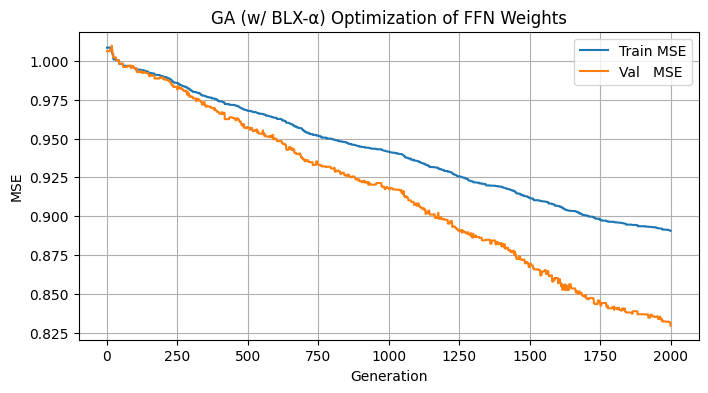

In [ ]:
"""
Genetic Algorithm (GA) with Increased BLX-α for Feed-Forward Neural Network Optimisation
=========================================================================================

This script implements a real-valued Genetic Algorithm (GA) to optimise the weights of a
Feed-Forward Neural Network (FFN) using BLX-α crossover and Gaussian mutation. The key
modification in this version is an increased elitism percentage.

Core Features:
--------------
- FFN with fixed architecture: 2 hidden layers, 24 units each, ReLU activations
- Xavier normal initialisation
- Real-valued GA using:
    * Tournament selection (size 3)
    * Elitism (top 20% retained)
    * BLX-α crossover with α = 0.6
    * Gaussian mutation (μ=0, σ=0.01) with mutation rate 1%
- Reproducibility via fixed seeds
- Evaluation on both training and validation sets using MSE loss
- Plot of MSE over generations

Key Hyperparameters:
--------------------
- `pop_size`: 200 (population size)
- `generations`: 2000 (evolution length)
- `elite_frac`: 0.2 (elitism retention)
- `tourn_size`: 3 (selection pressure)
- `blx_alpha`: 0.6 (exploration during crossover ↑)
- `mutation_p`: 0.01 (probability of mutation per gene)
- `mutation_sd`: 0.01 (standard deviation of Gaussian mutation)

Outputs:
--------
- Prints MSE every 100 generations
- Final training and validation MSE of the best individual
- Matplotlib plot showing training and validation MSE curves

Usage Instructions:
-------------------
- Ensure that `X_train`, `y_train`, `X_val`, and `y_val` are defined as PyTorch tensors.
- Adjust the architecture or GA hyperparameters if needed.
- Run the script to evolve the FFN weights and observe performance.

Remarks:
--------
This version increases the BLX-α crossover range, allowing offspring to explore further
beyond the bounds of the parent genes. This may help escape local minima in multimodal
landscapes but could also introduce more variance in early training.

"""

import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt
import torch.nn.init as init
import sklearn.decomposition as skPCA
#  0) Repro & Device 
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")
#  1) Data to device 
X_train_dev, y_train_dev = X_train.to(device), y_train.to(device)
X_val_dev,   y_val_dev   = X_val.to(device),   y_val.to(device)
#  2) Fixed Architecture + Xavier init 
arch = dict(n_layers=2, n_units=24, activation="ReLU")
init_scheme = "xavier_normal"
criterion   = nn.MSELoss()
def build_model():
    layers, in_f = [], X_train_dev.shape[1]
    Act = getattr(nn, arch["activation"])
    for _ in range(arch["n_layers"]):
        layers += [nn.Linear(in_f, arch["n_units"]), Act()]
        in_f = arch["n_units"]
    layers.append(nn.Linear(in_f,1))
    m = nn.Sequential(*layers).to(device)
    for L in m.modules():
        if isinstance(L, nn.Linear):
            init.xavier_normal_(L.weight)
    return m
#  3) GA Hyperparams 
pop_size    = 200
generations = 2000
elite_frac  = 0.2
tourn_size  = 3
mutation_p  = 0.01
mutation_sd = 0.01
blx_alpha   = 0.6
#  4) Init Population 
pop = []
for _ in range(pop_size):
    m = build_model()
    vec = parameters_to_vector(m.parameters()).detach().cpu().numpy().astype(np.float32)
    pop.append(vec)
#  visualize initial population 
pop_mat = np.stack(pop)           
genome_len = pop[0].size
#  5) Tournament Selection 
def tournament_select(pop, fitness):
    idxs = np.random.choice(pop_size, tourn_size, replace=False)
    best = idxs[np.argmin([fitness[i] for i in idxs])]
    return pop[best]
#  6) Evolution 
train_curve = []
val_curve   = []
best_norms = []
for gen in range(1, generations+1):
    # a) Fitness eval
    fitness = []
    for genome in pop:
        m = build_model()
        vector_to_parameters(torch.from_numpy(genome).to(device), m.parameters())
        with torch.no_grad():
            fitness.append(criterion(m(X_train_dev), y_train_dev).item())
    f = np.array(fitness)
    if gen == 1 or gen % 100 == 0:
        print(f"Gen {gen:2d}/{generations} ▶ train MSE: {tr_mse:.4f}, val MSE: {va_mse:.4f}")
    # record best
    best_idx = int(np.argmin(fitness))
    tr_mse   = fitness[best_idx]
    m_best   = build_model()
    vector_to_parameters(torch.from_numpy(pop[best_idx]).to(device), m_best.parameters())
    with torch.no_grad():
        va_mse = criterion(m_best(X_val_dev), y_val_dev).item()
    train_curve.append(tr_mse)
    val_curve.append(va_mse)
    # b) Elitism
    elite_n = max(1, int(elite_frac * pop_size))
    elites  = [pop[i] for i in np.argsort(fitness)[:elite_n]]
    pop_size   = len(pop)
    # selection probabilities
    p_elite   = 0
    p_tourn   = 1
    def sample_parent(pop, fitness):
        if (p_elite == 0 and p_tourn == 1):
            # pure tournament selection
            return tournament_select(pop, fitness)
        
    # c) Reproduce via BLX-α + mutation
    new_pop = elites.copy()
    while len(new_pop) < pop_size:
        p1 = sample_parent(pop, fitness)
        p2 = sample_parent(pop, fitness)
        # BLX-α crossover
        low  = np.minimum(p1,p2) - blx_alpha * np.abs(p1-p2)
        high = np.maximum(p1,p2) + blx_alpha * np.abs(p1-p2)
        child = np.random.uniform(low, high).astype(np.float32)
        # mutation
        mask  = np.random.rand(genome_len) < mutation_p
        noise = np.random.randn(genome_len).astype(np.float32) * mutation_sd
        child[mask] += noise[mask]
        new_pop.append(child)

    pop = new_pop
#  7) Final Best Model 
best_genome = pop[int(np.argmin(fitness))]
best_model_ga = build_model()
vector_to_parameters(torch.from_numpy(best_genome).to(device),
                     best_model_ga.parameters())
best_model_ga.eval()
with torch.no_grad():
    final_tr = criterion(best_model_ga(X_train_dev), y_train_dev).item()
    final_va = criterion(best_model_ga(X_val_dev),   y_val_dev).item()
print(f"\n✅ GA done!  Final Train MSE: {final_tr:.4f}, Val MSE: {final_va:.4f}")
#  8) Plot 
plt.figure(figsize=(8,4))
plt.plot(train_curve, label="Train MSE")
plt.plot(val_curve,   label="Val   MSE")
plt.xlabel("Generation")
plt.ylabel("MSE")
plt.title("GA (w/ BLX-α) Optimization of FFN Weights")
plt.legend()
plt.grid(True)
plt.show()


#### Best implementation from previous experiments, now increasing tournament size:

Using device: cuda

Gen  1/2000 ▶ train MSE: 0.8906, val MSE: 0.8294
Gen 100/2000 ▶ train MSE: 0.9938, val MSE: 0.9944
Gen 200/2000 ▶ train MSE: 0.9901, val MSE: 0.9904
Gen 300/2000 ▶ train MSE: 0.9875, val MSE: 0.9864
Gen 400/2000 ▶ train MSE: 0.9853, val MSE: 0.9842
Gen 500/2000 ▶ train MSE: 0.9835, val MSE: 0.9820
Gen 600/2000 ▶ train MSE: 0.9820, val MSE: 0.9805
Gen 700/2000 ▶ train MSE: 0.9806, val MSE: 0.9781
Gen 800/2000 ▶ train MSE: 0.9789, val MSE: 0.9753
Gen 900/2000 ▶ train MSE: 0.9770, val MSE: 0.9723
Gen 1000/2000 ▶ train MSE: 0.9755, val MSE: 0.9698
Gen 1100/2000 ▶ train MSE: 0.9742, val MSE: 0.9687
Gen 1200/2000 ▶ train MSE: 0.9731, val MSE: 0.9669
Gen 1300/2000 ▶ train MSE: 0.9710, val MSE: 0.9626
Gen 1400/2000 ▶ train MSE: 0.9698, val MSE: 0.9609
Gen 1500/2000 ▶ train MSE: 0.9687, val MSE: 0.9593
Gen 1600/2000 ▶ train MSE: 0.9671, val MSE: 0.9569
Gen 1700/2000 ▶ train MSE: 0.9659, val MSE: 0.9542
Gen 1800/2000 ▶ train MSE: 0.9647, val MSE: 0.9531
Gen 1900/2000 ▶ train 

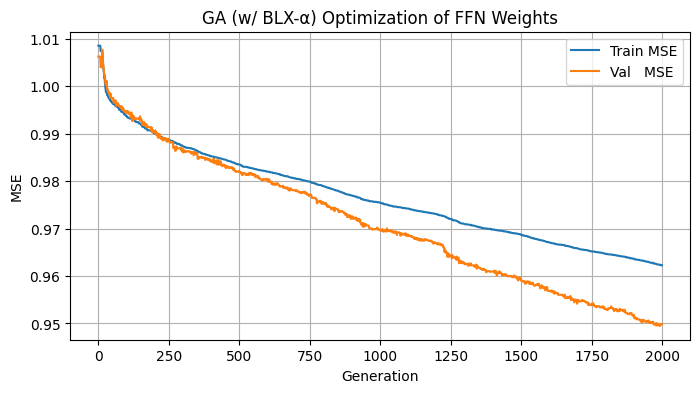

In [ ]:
"""
Genetic Algorithm (GA) with Larger Tournament Size for FFN Weight Optimisation
===============================================================================

This script evolves the weights of a fixed-architecture feed-forward neural network (FFN)
using a real-valued Genetic Algorithm. The crossover operator is BLX-α with α = 0.6,
and mutation is Gaussian. The key difference in this version is an **increased tournament
size (tourn_size = 5)** to apply stronger selective pressure during parent selection.

Key Features:
-------------
- Fixed FFN: 2 layers × 24 units, ReLU activations
- Xavier normal initialisation for consistency
- Real-valued genome (vector of FFN weights)
- BLX-α crossover (α = 0.6) for diversity
- Gaussian mutation (1% mutation rate, σ = 0.01)
- Tournament selection with size = 5 (↑ selective pressure)
- Elitism: top 20% of population preserved each generation

Hyperparameters:
----------------
- `pop_size`: 200
- `generations`: 2000
- `elite_frac`: 0.2
- `tourn_size`: 5  ← Increased from earlier runs
- `blx_alpha`: 0.6
- `mutation_p`: 0.01
- `mutation_sd`: 0.01

Outputs:
--------
- Printed MSE every 100 generations
- Final train/val MSE for best individual
- Plot of training and validation loss curves

"""

import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt
import torch.nn.init as init

#  0) Repro & Device 
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")
#  1) Data to device 
X_train_dev, y_train_dev = X_train.to(device), y_train.to(device)
X_val_dev,   y_val_dev   = X_val.to(device),   y_val.to(device)
#  2) Fixed Architecture + Xavier init 
arch = dict(n_layers=2, n_units=24, activation="ReLU")
init_scheme = "xavier_normal"
criterion   = nn.MSELoss()
def build_model():
    layers, in_f = [], X_train_dev.shape[1]
    Act = getattr(nn, arch["activation"])
    for _ in range(arch["n_layers"]):
        layers += [nn.Linear(in_f, arch["n_units"]), Act()]
        in_f = arch["n_units"]
    layers.append(nn.Linear(in_f,1))
    m = nn.Sequential(*layers).to(device)
    for L in m.modules():
        if isinstance(L, nn.Linear):
            init.xavier_normal_(L.weight)
    return m

#  3) GA Hyperparams 
pop_size    = 200
generations = 2000
elite_frac  = 0.2
tourn_size  = 5
mutation_p  = 0.01
mutation_sd = 0.01
blx_alpha   = 0.6

#  4) Init Population 
pop = []
for _ in range(pop_size):
    m = build_model()
    vec = parameters_to_vector(m.parameters()).detach().cpu().numpy().astype(np.float32)
    pop.append(vec)
import sklearn.decomposition as skPCA
#  visualize initial population 
pop_mat = np.stack(pop)         
genome_len = pop[0].size
#  5) Tournament Selection 
def tournament_select(pop, fitness):
    idxs = np.random.choice(pop_size, tourn_size, replace=False)
    best = idxs[np.argmin([fitness[i] for i in idxs])]
    return pop[best]
#  6) Evolution 
train_curve = []
val_curve   = []
best_norms = []
for gen in range(1, generations+1):
    # a) Fitness eval
    fitness = []
    for genome in pop:
        m = build_model()
        vector_to_parameters(torch.from_numpy(genome).to(device), m.parameters())
        with torch.no_grad():
            fitness.append(criterion(m(X_train_dev), y_train_dev).item())
    f = np.array(fitness)
    if gen == 1 or gen % 100 == 0:
        print(f"Gen {gen:2d}/{generations} ▶ train MSE: {tr_mse:.4f}, val MSE: {va_mse:.4f}")
    # record best
    best_idx = int(np.argmin(fitness))
    tr_mse   = fitness[best_idx]
    m_best   = build_model()
    vector_to_parameters(torch.from_numpy(pop[best_idx]).to(device), m_best.parameters())
    with torch.no_grad():
        va_mse = criterion(m_best(X_val_dev), y_val_dev).item()
    train_curve.append(tr_mse)
    val_curve.append(va_mse)
    # b) Elitism
    elite_n = max(1, int(elite_frac * pop_size))
    elites  = [pop[i] for i in np.argsort(fitness)[:elite_n]]
    pop_size   = len(pop)
    # selection probabilities
    p_elite   = 0
    p_tourn   = 1
    def sample_parent(pop, fitness):
        if (p_elite == 0 and p_tourn == 1):
            # pure tournament selection
            return tournament_select(pop, fitness)
    # c) Reproduce via BLX-α + mutation
    new_pop = elites.copy()
    while len(new_pop) < pop_size:
        p1 = sample_parent(pop, fitness)
        p2 = sample_parent(pop, fitness)
        # BLX-α crossover
        low  = np.minimum(p1,p2) - blx_alpha * np.abs(p1-p2)
        high = np.maximum(p1,p2) + blx_alpha * np.abs(p1-p2)
        child = np.random.uniform(low, high).astype(np.float32)
        # mutation
        mask  = np.random.rand(genome_len) < mutation_p
        noise = np.random.randn(genome_len).astype(np.float32) * mutation_sd
        child[mask] += noise[mask]
        new_pop.append(child)
    pop = new_pop
#  7) Final Best Model 
best_genome = pop[int(np.argmin(fitness))]
best_model_ga = build_model()
vector_to_parameters(torch.from_numpy(best_genome).to(device),
                     best_model_ga.parameters())
best_model_ga.eval()
with torch.no_grad():
    final_tr = criterion(best_model_ga(X_train_dev), y_train_dev).item()
    final_va = criterion(best_model_ga(X_val_dev),   y_val_dev).item()
print(f"\n✅ GA done!  Final Train MSE: {final_tr:.4f}, Val MSE: {final_va:.4f}")
#  8) Plot 
plt.figure(figsize=(8,4))
plt.plot(train_curve, label="Train MSE")
plt.plot(val_curve,   label="Val   MSE")
plt.xlabel("Generation")
plt.ylabel("MSE")
plt.title("GA (w/ BLX-α) Optimization of FFN Weights")
plt.legend()
plt.grid(True)
plt.show()


#### Hybrid GA: First implementation. Refine elites every 100 generations, for 10 epochs using gradient descent. Only run for 2000 generations.

Using device: cuda

Gen 1/2000 ▶ train MSE: 1.0075, val MSE: 1.0054
Gen 2/2000 ▶ train MSE: 1.0075, val MSE: 1.0054
Gen 3/2000 ▶ train MSE: 1.0075, val MSE: 1.0054
Gen 4/2000 ▶ train MSE: 1.0073, val MSE: 1.0051
Gen 5/2000 ▶ train MSE: 1.0073, val MSE: 1.0051
Gen 6/2000 ▶ train MSE: 1.0073, val MSE: 1.0051
Gen 7/2000 ▶ train MSE: 1.0073, val MSE: 1.0051
Gen 8/2000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 9/2000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 10/2000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 11/2000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 12/2000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 13/2000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 14/2000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 15/2000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 16/2000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 17/2000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 18/2000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 19/2000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 20/2000 ▶ train MSE: 1.0023, val MSE: 1.0025
Gen 21/20

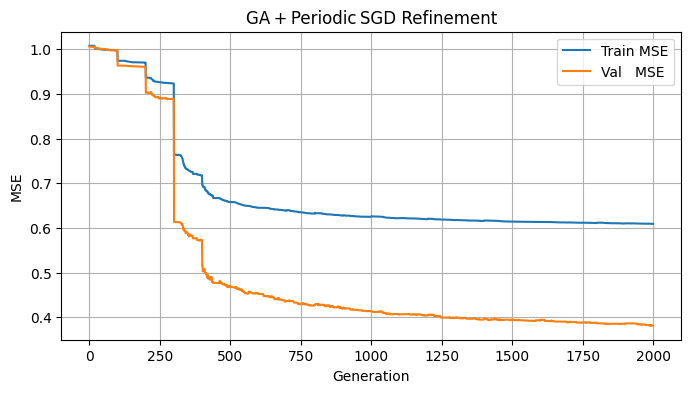

In [ ]:
"""
Hybrid Genetic Algorithm with Periodic SGD Refinement for FFN Training
=======================================================================

This script implements a hybrid optimisation strategy that combines a real-valued
Genetic Algorithm (GA) with periodic Stochastic Gradient Descent (SGD) refinement
for training a Feed-Forward Neural Network (FFN). The GA uses BLX-α crossover,
Gaussian mutation, and elitism. Every 100 generations, the top-performing elite
individuals are further fine-tuned using a fixed number of SGD epochs.

Key Innovations:
----------------
- Hybrid Strategy: Combines global GA exploration with local gradient-based exploitation
- Periodic Refinement: Every 100 generations, elite individuals undergo 10 epochs of SGD
- Logging: Logs elite MSEs before and after refinement to a CSV file for ablation and analysis

Core GA Configuration:
----------------------
- Population Size: 200
- Generations: 2000
- Elitism: top 20% retained per generation
- Tournament Selection: size 3
- Crossover: BLX-α with α = 0.6
- Mutation: Gaussian with probability 1%, std 0.01

SGD Refinement:
---------------
- Performed every 100 generations (`REFINE_EVERY`)
- Runs for 10 epochs (`REFINE_EPOCHS`) on each elite
- Uses momentum SGD with hyperparameters obtained via Optuna

Feedforward Network Architecture:
---------------------------------
- 2 hidden layers with 24 ReLU units each
- Xavier weight initialisation
- Output layer: linear (for regression)

Output:
-------
- Console logs for generation-wise MSE and refinement notifications
- `elite_mse_log.csv` file containing per-elite MSE before and after refinement
- Final training and validation MSE
- Matplotlib plot of training and validation MSE over time

Usage Notes:
------------
- Assumes `X_train`, `y_train`, `X_val`, `y_val` are pre-defined as `torch.Tensor`
- Designed for regression tasks (uses `nn.MSELoss`)
- Can be adapted to run refinement more/less frequently or to use other optimisers

"""


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.init as init
import matplotlib.pyplot as plt

#  1) Repro & Device 
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")
#  2) Hyperparameters 
# GA settings
POP_SIZE    = 200
GENERATIONS = 2000
ELITE_FRAC  = 0.2
TOURN_SIZE  = 3
MUT_P       = 0.01
MUT_SD      = 0.01
BLX_ALPHA   = 0.6

# Local SGD refinement (every REFINE_EVERY gens, on top ELITE_FRAC)
REFINE_EVERY = 100
REFINE_EPOCHS  = 10 
# FFN / SGD settings (from Optuna)
best_params = {
    "lr":         0.013988,
    "momentum":   0.6346,
    "batch_size": 32,
    "n_layers":   2,
    "n_units":    24,
    "activation": "ReLU"
}

#  3) DataPrep 
# assume X_train, y_train, X_val, y_val are already in scope as torch.Tensor
train_ds = TensorDataset(X_train.to(device), y_train.to(device))
train_loader = DataLoader(train_ds,
                          batch_size=best_params["batch_size"],
                          shuffle=True)

X_train_dev, y_train_dev = X_train.to(device), y_train.to(device)
X_val_dev,   y_val_dev   = X_val.to(device),   y_val.to(device)

#  4) Model Builder 
arch = dict(
    n_layers   = best_params["n_layers"],
    n_units    = best_params["n_units"],
    activation = best_params["activation"]
)
def build_model():
    """
    Constructs a feed-forward neural network (FFN) using the architecture specified in `arch`.
    
    The model includes:
    - `n_layers` hidden layers with `n_units` neurons each
    - Activation function as defined in `arch["activation"]`
    - Xavier normal weight initialization and zero-initialized biases

    Returns:
        nn.Module: A PyTorch sequential model moved to the appropriate device.
    """
    layers = []
    in_f = X_train_dev.shape[1]
    Act = getattr(nn, arch["activation"])
    for _ in range(arch["n_layers"]):
        layers += [nn.Linear(in_f, arch["n_units"]), Act()]
        in_f = arch["n_units"]
    layers.append(nn.Linear(in_f, 1))
    m = nn.Sequential(*layers).to(device)
    # Xavier init
    for L in m.modules():
        if isinstance(L, nn.Linear):
            init.xavier_normal_(L.weight)
            nn.init.zeros_(L.bias)
    return m
criterion = nn.MSELoss()

#  5) GA Helpers 
def tournament_select(pop, fitness):
    """
    Selects one individual from the population using tournament selection.

    Args:
        pop (list of np.ndarray): Population of genome vectors.
        fitness (list of float): Corresponding fitness values (lower is better).

    Returns:
        np.ndarray: Genome of the selected individual.
    """
    idxs = np.random.choice(len(pop), TOURN_SIZE, replace=False)
    best = idxs[np.argmin([fitness[i] for i in idxs])]
    return pop[best]

def crossover_and_mutate(p1, p2):
    """
    Produces a new child genome via BLX-α crossover and Gaussian mutation.

    - BLX-α expands the gene-wise search space around two parents.
    - Gaussian noise is added to a subset of genes based on mutation probability.

    Args:
        p1 (np.ndarray): Parent 1 genome.
        p2 (np.ndarray): Parent 2 genome.

    Returns:
        np.ndarray: Mutated child genome.
    """
    low  = np.minimum(p1,p2) - BLX_ALPHA * np.abs(p1-p2)
    high = np.maximum(p1,p2) + BLX_ALPHA * np.abs(p1-p2)
    child = np.random.uniform(low, high).astype(np.float32)
    # mutation
    mask  = np.random.rand(child.size) < MUT_P
    noise = np.random.randn(child.size).astype(np.float32) * MUT_SD
    child[mask] += noise[mask]
    return child

def refine_with_sgd(genome):

    """
    Produces a new child genome via BLX-α crossover and Gaussian mutation.

    - BLX-α expands the gene-wise search space around two parents.
    - Gaussian noise is added to a subset of genes based on mutation probability.

    Args:
        p1 (np.ndarray): Parent 1 genome.
        p2 (np.ndarray): Parent 2 genome.

    Returns:
        np.ndarray: Mutated child genome.
    """
    model = build_model()
    vector_to_parameters(torch.from_numpy(genome).to(device),
                         model.parameters())
    optim_sgd = optim.SGD(model.parameters(),
                          lr=best_params["lr"],
                          momentum=best_params["momentum"])
    model.train()
    for _ in range(REFINE_EPOCHS):
        print("refine step : ", _)
        for xb, yb in train_loader:
            optim_sgd.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optim_sgd.step()
    # write back
    return parameters_to_vector(model.parameters()).detach().cpu().numpy().astype(np.float32)

#  6) Initialize Population 
pop = []
for _ in range(POP_SIZE):
    m = build_model()
    vec = parameters_to_vector(m.parameters()).detach().cpu().numpy().astype(np.float32)
    pop.append(vec)
#  7) GA Main Loop 
train_curve, val_curve = [], []
###logging of mse values before and after sgd
LOG_FN = "elite_mse_log.csv"
# write header: gen,phase,elite0,elite1,…
with open(LOG_FN, "w") as f:
    # we'll fill in the number of elites after we know ELITE_FRAC and POP_SIZE
    elite_n = max(1, int(ELITE_FRAC * POP_SIZE))
    cols = ["gen","phase"] + [f"elite{i}" for i in range(elite_n)]
    f.write(",".join(cols) + "\n")

for gen in range(1, GENERATIONS+1):
    # a) evaluate all fitness
    fitness = []
    for genome in pop:
        m = build_model()
        vector_to_parameters(torch.from_numpy(genome).to(device), m.parameters())
        with torch.no_grad():
            fitness.append(criterion(m(X_train_dev), y_train_dev).item())
    fitness = np.array(fitness)
    # b) stats & record best
    best_idx = int(np.argmin(fitness))
    train_curve.append(fitness[best_idx])
    # validation mse of best
    m_best = build_model()
    vector_to_parameters(torch.from_numpy(pop[best_idx]).to(device), m_best.parameters())
    with torch.no_grad():
        val_curve.append(criterion(m_best(X_val_dev), y_val_dev).item())
    #if gen % 100 == 0 or gen == 1:
    print(f"Gen {gen}/{GENERATIONS} ▶ "
        f"train MSE: {fitness.min():.4f}, val MSE: {val_curve[-1]:.4f}")
    # c) elitism
    elite_n = max(1, int(ELITE_FRAC * POP_SIZE))
    elite_idxs = np.argsort(fitness)[:elite_n]
    elites = [pop[i] for i in elite_idxs]
    elite_tuned = max(1, int((ELITE_FRAC) * POP_SIZE))
    elite_tuned_idxs = np.argsort(fitness)[:elite_n]

    if gen % REFINE_EVERY == 0:
        # (re)compute your elite indices
        elite_n = max(1, int(ELITE_FRAC * POP_SIZE))
        elite_idxs = np.argsort(fitness)[:elite_n]
        # 1) capture “pre” MSEs
        pre_vals = fitness[elite_idxs]
        with open(LOG_FN, "a") as f:
            line = [str(gen), "pre"] + [f"{v:.6f}" for v in pre_vals]
            f.write(",".join(line) + "\n")
        # 2) do your SGD refine exactly as before
        print(f"\n--- Refinement @ gen {gen} ---")
        for i in elite_idxs:
            pop[i] = refine_with_sgd(pop[i])
        # 3) capture “post” MSEs (re‐evaluate on train set)
        post_vals = []
        for i in elite_idxs:
            m = build_model()
            vector_to_parameters(torch.from_numpy(pop[i]).to(device),
                                m.parameters())
            with torch.no_grad():
                post_vals.append(criterion(m(X_train_dev), y_train_dev).item())

        with open(LOG_FN, "a") as f:
            line = [str(gen), "post"] + [f"{v:.6f}" for v in post_vals]
            f.write(",".join(line) + "\n")
    # e) selection + reproduction
    new_pop = [ pop[i] for i in elite_idxs ] 
    new_popa = elites.copy()
    # show that new_pop still points at the old arrays A, B, C… not your refined ones
    while len(new_pop) < POP_SIZE:
        p1 = tournament_select(pop, fitness)
        p2 = tournament_select(pop, fitness)
        child = crossover_and_mutate(p1, p2)
        new_pop.append(child)
    pop = new_pop
#  8) Final Eval & Plot 
best_idx = int(np.argmin(fitness))
best_genome = pop[best_idx]
best_model  = build_model()
vector_to_parameters(torch.from_numpy(best_genome).to(device), best_model.parameters())
with torch.no_grad():
    final_tr = criterion(best_model(X_train_dev), y_train_dev).item()
    final_va = criterion(best_model(X_val_dev),   y_val_dev).item()
print(f"\n✅ GA+SGD done!  Final Train MSE: {final_tr:.4f}, Val MSE: {final_va:.4f}")
plt.figure(figsize=(8,4))
plt.plot(train_curve, label="Train MSE")
plt.plot(val_curve,   label="Val   MSE")
plt.xlabel("Generation")
plt.ylabel("MSE")
plt.title("GA + Periodic SGD Refinement")
plt.legend()
plt.grid(True)
plt.show()


#### Final hybrid GA implementation: Final run: Stop SGD refining after 600 generations due to divergence of solutions.

Using device: cuda

Gen 1/8000 ▶ train MSE: 1.0075, val MSE: 1.0054
Gen 2/8000 ▶ train MSE: 1.0075, val MSE: 1.0054
Gen 3/8000 ▶ train MSE: 1.0075, val MSE: 1.0054
Gen 4/8000 ▶ train MSE: 1.0073, val MSE: 1.0051
Gen 5/8000 ▶ train MSE: 1.0073, val MSE: 1.0051
Gen 6/8000 ▶ train MSE: 1.0073, val MSE: 1.0051
Gen 7/8000 ▶ train MSE: 1.0073, val MSE: 1.0051
Gen 8/8000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 9/8000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 10/8000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 11/8000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 12/8000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 13/8000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 14/8000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 15/8000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 16/8000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 17/8000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 18/8000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 19/8000 ▶ train MSE: 1.0072, val MSE: 1.0051
Gen 20/8000 ▶ train MSE: 1.0023, val MSE: 1.0025
Gen 21/80

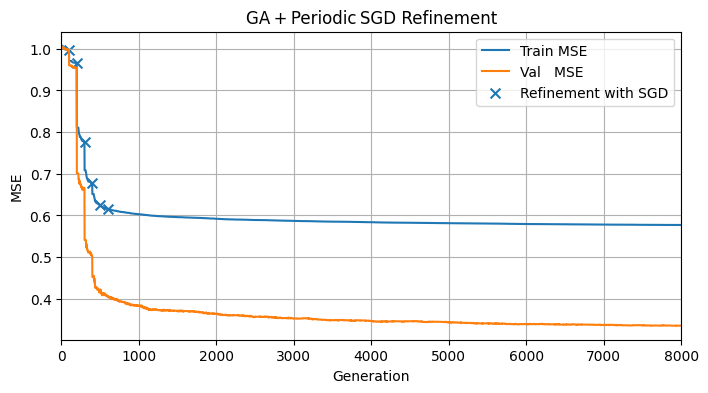

In [ ]:

"""
Hybrid Genetic Algorithm with Periodic SGD Refinement for FFN Training
=======================================================================

This script implements a hybrid optimisation strategy that combines a real-valued
Genetic Algorithm (GA) with periodic Stochastic Gradient Descent (SGD) refinement
for training a Feed-Forward Neural Network (FFN). The GA uses BLX-α crossover,
Gaussian mutation, and elitism. Every 100 generations, the top-performing elite
individuals are further fine-tuned using a fixed number of SGD epochs.

Key Innovations:
----------------
- Hybrid Strategy: Combines global GA exploration with local gradient-based exploitation
- Periodic Refinement: Every 100 generations, elite individuals undergo 10 epochs of SGD
- Logging: Logs elite MSEs before and after refinement to a CSV file for ablation and analysis
- Now stops refining after generation 600

Core GA Configuration:
----------------------
- Population Size: 200
- Generations: 2000
- Elitism: top 20% retained per generation
- Tournament Selection: size 3
- Crossover: BLX-α with α = 0.6
- Mutation: Gaussian with probability 1%, std 0.01

SGD Refinement:
---------------
- Performed every 100 generations (`REFINE_EVERY`)
- Runs for 10 epochs (`REFINE_EPOCHS`) on each elite
- Uses momentum SGD with hyperparameters obtained via Optuna

Feedforward Network Architecture:
---------------------------------
- 2 hidden layers with 24 ReLU units each
- Xavier weight initialisation
- Output layer: linear (for regression)

Output:
-------
- Console logs for generation-wise MSE and refinement notifications
- `elite_mse_log.csv` file containing per-elite MSE before and after refinement
- Final training and validation MSE
- Matplotlib plot of training and validation MSE over time

Usage Notes:
------------
- Assumes `X_train`, `y_train`, `X_val`, `y_val` are pre-defined as `torch.Tensor`
- Designed for regression tasks (uses `nn.MSELoss`)
- Can be adapted to run refinement more/less frequently or to use other optimisers

"""
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.init as init
import matplotlib.pyplot as plt
import time
import json
import os

#  1) Repro & Device 
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")
#  2) Hyperparameters 
# GA settings
POP_SIZE    = 200
GENERATIONS = 8000
ELITE_FRAC  = 0.2
TOURN_SIZE  = 3
MUT_P       = 0.01
MUT_SD      = 0.01
BLX_ALPHA   = 0.6

# Local SGD refinement (every REFINE_EVERY gens, on top ELITE_FRAC)
REFINE_EVERY = 100
REFINE_EPOCHS  = 10 
# FFN / SGD settings (from Optuna)
best_params = {
    "lr":         0.013988,
    "momentum":   0.6346,
    "batch_size": 32,
    "n_layers":   2,
    "n_units":    24,
    "activation": "ReLU"
}

#  3) DataPrep 
# assume X_train, y_train, X_val, y_val are already in scope as torch.Tensor
train_ds = TensorDataset(X_train.to(device), y_train.to(device))
train_loader = DataLoader(train_ds,
                          batch_size=best_params["batch_size"],
                          shuffle=True)

X_train_dev, y_train_dev = X_train.to(device), y_train.to(device)
X_val_dev,   y_val_dev   = X_val.to(device),   y_val.to(device)

# ─── 4) Model Builder ─────────────────────────────────────────────────────────
arch = dict(
    n_layers   = best_params["n_layers"],
    n_units    = best_params["n_units"],
    activation = best_params["activation"]
)
def build_model():
    """
    Constructs a feed-forward neural network (FFN) using the architecture specified in `arch`.
    
    The model includes:
    - `n_layers` hidden layers with `n_units` neurons each
    - Activation function as defined in `arch["activation"]`
    - Xavier normal weight initialization and zero-initialized biases

    Returns:
        nn.Module: A PyTorch sequential model moved to the appropriate device.
    """
    layers = []
    in_f = X_train_dev.shape[1]
    Act = getattr(nn, arch["activation"])
    for _ in range(arch["n_layers"]):
        layers += [nn.Linear(in_f, arch["n_units"]), Act()]
        in_f = arch["n_units"]
    layers.append(nn.Linear(in_f, 1))
    m = nn.Sequential(*layers).to(device)
    # Xavier init
    for L in m.modules():
        if isinstance(L, nn.Linear):
            init.xavier_normal_(L.weight)
            nn.init.zeros_(L.bias)
    return m
criterion = nn.MSELoss()
#  5) GA Helpers 
def tournament_select(pop, fitness):
    """
    Selects one individual from the population using tournament selection.

    Args:
        pop (list of np.ndarray): Population of genome vectors.
        fitness (list of float): Corresponding fitness values (lower is better).

    Returns:
        np.ndarray: Genome of the selected individual.
    """
    idxs = np.random.choice(len(pop), TOURN_SIZE, replace=False)
    best = idxs[np.argmin([fitness[i] for i in idxs])]
    return pop[best]

def crossover_and_mutate(p1, p2):
    """
    Produces a new child genome via BLX-α crossover and Gaussian mutation.

    - BLX-α expands the gene-wise search space around two parents.
    - Gaussian noise is added to a subset of genes based on mutation probability.

    Args:
        p1 (np.ndarray): Parent 1 genome.
        p2 (np.ndarray): Parent 2 genome.

    Returns:
        np.ndarray: Mutated child genome.
    """
    low  = np.minimum(p1,p2) - BLX_ALPHA * np.abs(p1-p2)
    high = np.maximum(p1,p2) + BLX_ALPHA * np.abs(p1-p2)
    child = np.random.uniform(low, high).astype(np.float32)
    # mutation
    mask  = np.random.rand(child.size) < MUT_P
    noise = np.random.randn(child.size).astype(np.float32) * MUT_SD
    child[mask] += noise[mask]
    return child

def refine_with_sgd(genome):
    """
    Produces a new child genome via BLX-α crossover and Gaussian mutation.

    - BLX-α expands the gene-wise search space around two parents.
    - Gaussian noise is added to a subset of genes based on mutation probability.

    Args:
        p1 (np.ndarray): Parent 1 genome.
        p2 (np.ndarray): Parent 2 genome.

    Returns:
        np.ndarray: Mutated child genome.
    """
    model = build_model()
    vector_to_parameters(torch.from_numpy(genome).to(device),
                         model.parameters())
    optim_sgd = optim.SGD(model.parameters(),
                          lr=best_params["lr"],
                          momentum=best_params["momentum"])
    model.train()
    for _ in range(REFINE_EPOCHS):
        
        for xb, yb in train_loader:
            optim_sgd.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optim_sgd.step()
    # write back
    return parameters_to_vector(model.parameters()).detach().cpu().numpy().astype(np.float32)
#  6) Initialize Population 
pop = []
for _ in range(POP_SIZE):
    m = build_model()
    vec = parameters_to_vector(m.parameters()).detach().cpu().numpy().astype(np.float32)
    pop.append(vec)
#  7) GA Main Loop 
train_curve, val_curve = [], []
###logging of mse values before and after sgd
LOG_FN = "elite_mse_log.csv"
# write header: gen,phase,elite0,elite1,…
with open(LOG_FN, "w") as f:
    # we'll fill in the number of elites after we know ELITE_FRAC and POP_SIZE
    elite_n = max(1, int(ELITE_FRAC * POP_SIZE))
    cols = ["gen","phase"] + [f"elite{i}" for i in range(elite_n)]
    f.write(",".join(cols) + "\n")

GRAPH_LOG_FN = "graph_logs.csv"
with open(GRAPH_LOG_FN, "w") as gf:
    gf.write("gen,mean_pop,mean_elite_pre,mean_elite_post,best_new,mean_children,gen_time\n")

#----------------------------------------------------------------------#
#Start of generations:
for gen in range(1, GENERATIONS+1):
    start_time = time.time()
    # a) evaluate all fitness
    fitness = []
    for genome in pop:
        m = build_model()
        vector_to_parameters(torch.from_numpy(genome).to(device), m.parameters())
        with torch.no_grad():
            fitness.append(criterion(m(X_train_dev), y_train_dev).item())
    fitness = np.array(fitness)
    #calculate mean fitness of pop
    mean_pop = fitness.mean()
    best_idx = int(np.argmin(fitness))
    train_curve.append(fitness[best_idx])
    # validation mse of best
    m_best = build_model()
    vector_to_parameters(torch.from_numpy(pop[best_idx]).to(device), m_best.parameters())
    with torch.no_grad():
        val_curve.append(criterion(m_best(X_val_dev), y_val_dev).item())
    print(f"Gen {gen}/{GENERATIONS} ▶ "
        f"train MSE: {fitness.min():.4f}, val MSE: {val_curve[-1]:.4f}")
    # c) elitism
    elite_n = max(1, int(ELITE_FRAC * POP_SIZE))
    elite_idxs = np.argsort(fitness)[:elite_n]
    #Elite fitness meaan pre 
    mean_elite_pre = fitness[elite_idxs].mean()
    elites = [pop[i] for i in elite_idxs]
    #Mean elite post, intiialised the same
    mean_elite_post = mean_elite_pre
    #Fitness of elites by indexing into the fitness array:
    elites_fitness = fitness[elite_idxs]

    mean_of_prerefined_elites = np.mean(elites_fitness)
   
    if gen % REFINE_EVERY == 0 and gen < 699:
        elite_n = max(1, int(ELITE_FRAC * POP_SIZE))
        elite_idxs = np.argsort(fitness)[:elite_n]
        pre_vals = fitness[elite_idxs]
        with open(LOG_FN, "a") as f:
            line = [str(gen), "pre"] + [f"{v:.6f}" for v in pre_vals]
            f.write(",".join(line) + "\n")
        print(f"\n--- Refinement @ gen {gen} ---")
        for i in elite_idxs:
            pop[i] = refine_with_sgd(pop[i])
        post_vals = []
        for i in elite_idxs:
            m = build_model()
            vector_to_parameters(torch.from_numpy(pop[i]).to(device),
                                m.parameters())
            with torch.no_grad():
                post_vals.append(criterion(m(X_train_dev), y_train_dev).item())
            mean_elite_post = np.mean(post_vals)
        with open(LOG_FN, "a") as f:
            line = [str(gen), "post"] + [f"{v:.6f}" for v in post_vals]
            f.write(",".join(line) + "\n")
    # e) selection + reproduction
    new_pop = [ pop[i] for i in elite_idxs ] 
    while len(new_pop) < POP_SIZE:
        p1 = tournament_select(pop, fitness)
        p2 = tournament_select(pop, fitness)
        child = crossover_and_mutate(p1, p2)
        new_pop.append(child)
    pop = new_pop
    # 5) Recompute fitness on the replaced population
    new_fitness = []
    for genome in pop:
        m = build_model()
        vector_to_parameters(torch.from_numpy(genome).to(device), m.parameters())
        with torch.no_grad():
            new_fitness.append(criterion(m(X_train_dev), y_train_dev).item())
    new_fitness = np.array(new_fitness)
    # best MSE in the new population
    best_new = new_fitness.min()
    # mean MSE of _just_ the children (everything after the first `elite_n` slots)
    if POP_SIZE > elite_n:
        mean_children = new_fitness[elite_n:].mean()
    else:
        mean_children = float("nan")
    gen_time = time.time() - start_time
    with open(GRAPH_LOG_FN, "a") as gf:
        gf.write(
            f"{gen},"
            f"{mean_pop:.6f},"
            f"{mean_elite_pre:.6f},"
            f"{mean_elite_post:.6f},"
            f"{best_new:.6f},"
            f"{mean_children:.6f},"
            f"{gen_time:.3f}\n"
        )

    # ─── very final: recompute fitness on the updated pop ─────────────────
    fitness = []
    for genome in pop:
        m = build_model()
        vector_to_parameters(torch.from_numpy(genome).to(device),
                                m.parameters())
        with torch.no_grad():
            fitness.append(criterion(m(X_train_dev), y_train_dev).item())
    fitness = np.array(fitness)

#  8) Final Eval & Plot 
best_idx = int(np.argmin(fitness))
best_genome = pop[best_idx]
best_model  = build_model()
vector_to_parameters(torch.from_numpy(best_genome).to(device), best_model.parameters())
with torch.no_grad():
    final_tr = criterion(best_model(X_train_dev), y_train_dev).item()
    final_va = criterion(best_model(X_val_dev),   y_val_dev).item()

print(f"\n✅ GA+SGD done!  Final Train MSE: {final_tr:.4f}, Val MSE: {final_va:.4f}")
os.makedirs("checkpoints", exist_ok=True)
# 1) Save the PyTorch state_dict
torch.save(best_model.state_dict(),
           "checkpoints/best_model_weights.pth")
# 2) Save the flat genome vector (numpy array)
np.save("checkpoints/best_genome.npy", best_genome)
# 3) (Optional) Save arch + Optuna params so you can rebuild the same model
meta = {
    "arch": arch,
    "best_params": best_params
}
with open("checkpoints/best_model_meta.json","w") as fp:
    json.dump(meta, fp, indent=2)
print("✅ Best model weights, genome and metadata saved to ./checkpoints/")
plt.figure(figsize=(8,4))
plt.plot(train_curve, label="Train MSE")
plt.plot(val_curve,   label="Val   MSE")
refine_gens = [100, 200, 300, 400, 500, 600]
refine_gens = [g for g in refine_gens if g <= len(train_curve)]
refine_vals = [train_curve[g-1] for g in refine_gens]
plt.scatter(refine_gens, refine_vals, marker='x', s=50, label='Refinement with SGD')
plt.xlim(0, 8000)
plt.xlabel("Generation")
plt.ylabel("MSE")
plt.title("GA + Periodic SGD Refinement")
plt.legend()
plt.grid(True)
plt.show()


#### Final test set evaluation of all three optimisers best models:
#### NOTE : All cells before this must be run before running this one.

GA     → Test MSE (scaled):   0.332427
GA     → Test MSE (original): 67.030509
GA     → Test RMSE (original): 8.1872

SGD    → Test MSE (scaled):   0.504205
SGD    → Test MSE (original): 101.667889
SGD    → Test RMSE (original): 10.0830

L-BFGS → Test MSE (scaled):   0.354872
L-BFGS → Test MSE (original): 71.556357
L-BFGS → Test RMSE (original): 8.4591



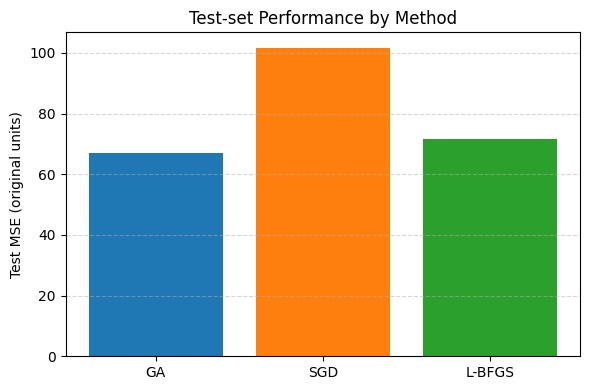

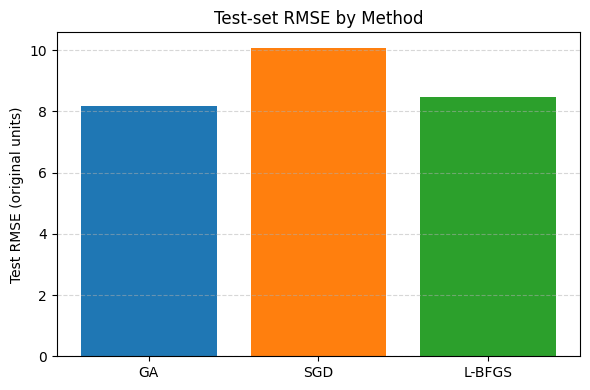

In [ ]:
# ─── 3) Evaluate each checkpointed model ────────────────────────────────────
"""
Evaluates the performance of each trained model (GA, SGD, L-BFGS) on the test set.

For each method:
- Loads model architecture and weights from checkpoint
- Runs forward pass on test data (scaled)
- Converts predictions back to original scale
- Computes test MSE and RMSE in both scaled and original units
- Logs results and saves predictions for downstream use
"""


#  Evaluate each checkpointed model 
results = []
all_preds = {}
rmse_results = []

for method, ckpt_dir, weight_file, meta_file in [
    ("GA",    "checkpoints",         "best_model_weights.pth",  "best_model_meta.json"),
    ("SGD",   "checkpoints_sgd",     "sgd_final_weights.pth",   "sgd_model_meta.json"),
    ("L-BFGS","checkpoints_lbfgs",   "lbfgs_final_weights.pth", "lbfgs_model_meta.json"),
]:
    # load architecture meta
    meta   = json.load(open(os.path.join(ckpt_dir, meta_file), "r"))
    arch   = meta["arch"]
    model  = build_model_from_arch(arch)
    # load weights
    state  = torch.load(os.path.join(ckpt_dir, weight_file), map_location=device)
    model.load_state_dict(state)
    model.eval()
    # forward on test set
    with torch.no_grad():
        y_pred_scaled = model(X_test).cpu().numpy()
    y_pred_orig = scaler_y.inverse_transform(y_pred_scaled)
    y_true_orig = y_test_np
    # MSE in scaled and original units
    mse_scaled    = np.mean((y_pred_scaled - y_test.cpu().numpy())**2)
    mse_original  = np.mean((y_pred_orig   - y_true_orig)**2)
    rmse_original = np.sqrt(mse_original)

    print(f"{method:6s} → Test MSE (scaled):   {mse_scaled:.6f}")
    print(f"{method:6s} → Test MSE (original): {mse_original:.6f}")
    print(f"{method:6s} → Test RMSE (original): {rmse_original:.4f}\n")

    results.append((method, mse_scaled, mse_original))
    rmse_results.append((method, rmse_original))
    all_preds[method] = y_pred_orig.squeeze()

#  5) Bar‐plot of test MSE (original units) 
methods, _, orig_mses = zip(*results)
plt.figure(figsize=(6,4))
plt.bar(methods, orig_mses, color=["C0","C1","C2"])
plt.ylabel("Test MSE (original units)")
plt.title("Test-set Performance by Method")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

#  5b) Bar‐plot of test RMSE (original units) 
methods_rmse, rmses = zip(*rmse_results)
plt.figure(figsize=(6,4))
plt.bar(methods_rmse, rmses, color=["C0", "C1", "C2"])
plt.ylabel("Test RMSE (original units)")
plt.title("Test-set RMSE by Method")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

